In [1]:
import numpy as np
import numpy.linalg as lia
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn import svm 
from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn.naive_bayes import GaussianNB
import time

In [2]:
#run_search will perform the gridsearch in order to run the tests to plot graphs
#if run_search = False, there will be no plots
#ONLY TURN RUN_SEARCH TO TRUE IF YOU HAVE 5 HOURS TO SPARE
run_search = True

In [3]:
digits = datasets.load_digits()
wine = fetch_openml(name='wine', version=1)

In [4]:
# normalization of digits and wine data

digits_data_norm = []

for col in digits.data:
    col_norm = col/np.max(col)
    digits_data_norm.append(col_norm)

digits.data = np.asarray(digits_data_norm)

wine_data_norm = []

for col in wine.data.T:
    col_norm = col/np.amax(col)
    wine_data_norm.append(col_norm)
    
wine.data = np.asarray(wine_data_norm).T

In [5]:
# 5-fold cross validation for digits dataset

digitsTrainingSetSize = int(np.ceil(0.8 * len(digits.data)))
digitsValidationSetSize = int(len(digits.data) - digitsTrainingSetSize)

xDigitsTrainingSets = []
yDigitsTrainingSets = []
xDigitsValidationSets = []
yDigitsValidationSets = []

for foldIndex in range(5):

    xValidationSet = []
    yValidationSet = []

    for index, data in enumerate(digits.data[foldIndex*digitsValidationSetSize:((foldIndex*digitsValidationSetSize)+digitsValidationSetSize)]):
        xValidationSet.append(data.tolist())
        yValidationSet.append(digits.target[index+(foldIndex*digitsValidationSetSize)])
    
    xTrainingSet = []
    yTrainingSet = []

    for index, data in enumerate(digits.data.tolist()):
        if data not in xValidationSet:
            xTrainingSet.append(data)
            yTrainingSet.append(digits.target[index])
            
    xDigitsTrainingSets.append(xTrainingSet)
    yDigitsTrainingSets.append(yTrainingSet)
    xDigitsValidationSets.append(xValidationSet)
    yDigitsValidationSets.append(yValidationSet)
    
# 5-fold cross validation for wine dataset

wineTrainingSetSize = int(np.ceil(0.8 * len(wine.data)))
wineValidationSetSize = int(len(wine.data) - wineTrainingSetSize)

xWineTrainingSets = []
yWineTrainingSets = []
xWineValidationSets = []
yWineValidationSets = []

for foldIndex in range(5):

    xValidationSet = []
    yValidationSet = []
    for index, data in enumerate(wine.data[foldIndex*wineValidationSetSize:((foldIndex*wineValidationSetSize)+wineValidationSetSize)]):
        xValidationSet.append(data.tolist())
        yValidationSet.append(wine.target[index+(foldIndex*wineValidationSetSize)])
    
    xTrainingSet = []
    yTrainingSet = []
    
    for index, data in enumerate(wine.data.tolist()):
        if data not in xValidationSet:
            xTrainingSet.append(data)
            yTrainingSet.append(wine.target[index])
            
    xWineTrainingSets.append(xTrainingSet)
    yWineTrainingSets.append(yTrainingSet)
    xWineValidationSets.append(xValidationSet)
    yWineValidationSets.append(yValidationSet)

In [6]:
# one-hot encoding of y for digits dataset

numberOfDigitsTargets = 10
numberOfWineTargets = 3

for index, fold in enumerate(yDigitsTrainingSets):
    encodedFold = []
    for i, y in enumerate(fold):
        encoding = np.zeros(numberOfDigitsTargets)
        encoding[y] = 1
        encodedFold.append(encoding.tolist())
    yDigitsTrainingSets[index] = encodedFold
    
for index, fold in enumerate(yDigitsValidationSets):
    encodedFold = []
    for i, y in enumerate(fold):
        encoding = np.zeros(numberOfDigitsTargets)
        encoding[y] = 1
        encodedFold.append(encoding.tolist())
    yDigitsValidationSets[index] = encodedFold

# one-hot encoding of y for wine dataset

for index, fold in enumerate(yWineTrainingSets):
    encodedFold = []
    for i, y in enumerate(fold):
        encoding = np.zeros(numberOfWineTargets)
        encoding[int(y)-1] = 1
        encodedFold.append(encoding.tolist())
    yWineTrainingSets[index] = encodedFold
    
for index, fold in enumerate(yWineValidationSets):
    encodedFold = []
    for i, y in enumerate(fold):
        encoding = np.zeros(numberOfWineTargets)
        encoding[int(y)-1] = 1
        encodedFold.append(encoding.tolist())
    yWineValidationSets[index] = encodedFold


In [7]:
def getRandomIndices(arr, batch_size):
    indices = []
    
    if batch_size > len(arr):
        print("Error: batch size larger than size of dataset.")
        return
    
    while batch_size > 0:
        x = np.floor(np.random.random() * len(arr))
        if x not in indices:
            indices.append(int(x))
            batch_size -= 1
    
    return indices

In [8]:
# gradient descent class
 
class GradientDescent:
    
    def __init__(self, batch_size, learning_rate=0.5, momentum=0.9, max_termination_condition=25, max_iters=1000):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.batch_size = batch_size
        self.max_termination_condition = max_termination_condition
        self.max_iters = max_iters
        self.deltas = []
        
    def run(self, gradient_fn, x, y, w, vx, vy):
        t = 1
        
        max_cost = np.inf
        termination_count = 0        
        weight_history = []
        error_history = []
                
        for number_of_targets in range(len(y[0])):
            weight_history.append([])
        
        while termination_count < self.max_termination_condition and t < self.max_iters:
            gradients = gradient_fn(x, y, w, self.batch_size)   
            
            for c in range(len(y[0])):
                if(t==1):
                    w[c] = w[c] - self.learning_rate * gradients[c]
                else:
                    delta_w = (self.momentum)*(self.deltas[-(len(y[0]))]) + (1-self.momentum)*gradients[c]
                    w[c] = w[c] - (self.learning_rate)*(delta_w)
                self.deltas.append(w[c])
            
            a = np.asarray(vx)
            b = np.asarray(w)
    
            vyh=[]
        
            for i, vx_c in enumerate(a):
                vyh_x=[]

                for c in range(len(b)):
                    w_x =  b[c] @ vx_c
                    num = np.exp(w_x)

                    den = 0
                    
                    for i in range(len(b)):
                        w_x =  b[i] @ vx_c
                        den += np.exp(w_x)

                    vyh_c = num/den
                    vyh_x.append(vyh_c)
                    
                vyh.append(vyh_x)
                
            step_cost = 0
                
            def cost(yh, y):
                return y * np.log1p(np.exp(-yh)) + (1-yh) * np.log1p(np.exp(yh))
                
            for sample_index, vyh_x in enumerate(vyh):
                c = np.argmax(vy[sample_index])
                cst = cost(vyh_x[c], vy[sample_index][c])
                step_cost += cst
            
            for c in range(len(b)):
                weight_history[c].append(w[c])
            
            error_history.append(step_cost)

            if step_cost < max_cost:
                max_cost = step_cost
                termination_count = 0
                print(f"\t\tStep {t}: new best cost of {step_cost:.3f}")
            else:
                termination_count += 1
                print(f"\t\tStep {t}")
            
            t += 1
        
        index_best = len(error_history)-self.max_termination_condition-1
        
        w_best = []
        
        for c in range(len(y[0])):
            w_best.append(weight_history[c][index_best])
        
        return w_best

In [9]:
# logistic regression

class LogisticRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass
            
    def fit(self, x, y, optimizer, vx, vy):
        def gradient(x, y, w, batch_size):
            gradients = np.zeros(len(w)).tolist()

            indices = getRandomIndices(x, batch_size)

            for index in indices:
                a = np.asarray(x[index])
                b = np.asarray(y[index])

                for c in range(len(b)):
                    w_x =  w[c] @ a
                    num = np.exp(w_x)

                    den = 0
                    for i in range(len(b)):
                        w_x =  w[i] @ a
                        den += np.exp(w_x)

                    yh_c = num/den

                    y_c = b[c]
                    
                    cost_c = np.dot(yh_c - y_c, a)
                    
                    gradients[c] += cost_c

            return gradients
        
        if self.add_bias:
            x = np.asarray(x)
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
            
            vx = np.asarray(vx)
            vN = vx.shape[0]
            vx = np.column_stack([vx,np.ones(vN)])

        w0 = []
        for c in range(len(y[0])):
            w0.append(np.zeros(len(x[0])))
            
        self.w = optimizer.run(gradient, x, y, w0, vx, vy)
        return self
    
    def predict(self, x):
        if self.add_bias:
            x = np.asarray(x)
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])

        a = np.asarray(x)
        b = np.asarray(self.w)

        yh=[]
        
        for i, x_c in enumerate(a):
            yh_x=[]
            
            for c in range(len(b)):
                w_x =  b[c] @ x_c
                num = np.exp(w_x)

                den = 0
                
                for i in range(len(b)):
                    w_x =  b[i] @ x_c
                    den += np.exp(w_x)

                yh_c = num/den
                yh_x.append(yh_c)
                
            yh.append(yh_x)
        
        return yh

In [10]:
def runLogisticRegression(batch_size, learning_rate, momentum):
    def accurate(a, b):
        return np.argmax(a) == np.argmax(b)

    def cost(yh, y):
        return y * np.log1p(np.exp(-yh)) + (1-yh) * np.log1p(np.exp(yh))

    print("Model hyper-parameters:")
    print("\tMini-batch size:", batch_size)
    print("\tLearning rate:", learning_rate)
    print("\tMomentum:", momentum)
    print("\n")

    digits_training_accuracy = 0
    digits_training_cost = 0
    digits_validation_accuracy = 0
    digits_validation_cost = 0
    digits_runtime = 0
    wine_runtime = 0
    
    print("Digits gradient descent:")

    for fold_index, fold in enumerate(xDigitsTrainingSets):
        print(f"\tCross-validation fold {fold_index+1}")

        gradientDescentModel = GradientDescent(batch_size, learning_rate, momentum)
        logisticRegressionModel = LogisticRegression(add_bias=True)

        # Record amount of time taken for fit        
        startTime_fit = int(round(time.time() * 1000)) # Milliseconds
        logisticRegressionModel.fit(fold, yDigitsTrainingSets[fold_index], gradientDescentModel, xDigitsValidationSets[fold_index], yDigitsValidationSets[fold_index])
        endTime_fit = -1 * (startTime_fit - int(round(time.time() * 1000))) # <------------
        digits_runtime += endTime_fit
        
        yh_training = logisticRegressionModel.predict(xDigitsTrainingSets[fold_index])
        yh_validation = logisticRegressionModel.predict(xDigitsValidationSets[fold_index])

        for sample_index, yh_x in enumerate(yh_training):
            if accurate(yh_x, yDigitsTrainingSets[fold_index][sample_index]):
                digits_training_accuracy += 1
            c = np.argmax(yDigitsTrainingSets[fold_index][sample_index])
            cst = cost(yh_x[c], yDigitsTrainingSets[fold_index][sample_index][c])
            digits_training_cost += cst

        for sample_index, yh_x in enumerate(yh_validation):
            if accurate(yh_x, yDigitsValidationSets[fold_index][sample_index]):
                digits_validation_accuracy += 1
            c = np.argmax(yDigitsValidationSets[fold_index][sample_index])
            cst = cost(yh_x[c], yDigitsValidationSets[fold_index][sample_index][c])
            digits_validation_cost += cst

    digits_training_accuracy /= 4*len(digits.data)
    digits_training_cost /= 4
    digits_validation_accuracy /= len(digits.data)

    wine_training_accuracy = 0
    wine_training_cost = 0
    wine_validation_accuracy = 0
    wine_validation_cost = 0
    
    
    print("Wine gradient descent:")

    for fold_index, fold in enumerate(xWineTrainingSets):
        print(f"\tCross-validation fold {fold_index+1}")

        gradientDescentModel = GradientDescent(batch_size, learning_rate, momentum)
        logisticRegressionModel = LogisticRegression(add_bias=True)

        # Record amount of time taken for fit
        startTime_fit = int(round(time.time() * 1000))
        logisticRegressionModel.fit(fold, yWineTrainingSets[fold_index], gradientDescentModel, xWineValidationSets[fold_index], yWineValidationSets[fold_index])
        endTime_fit = -1 * (startTime_fit - int(round(time.time() * 1000))) # <------------
        wine_runtime += endTime_fit

        
        yh_training = logisticRegressionModel.predict(xWineTrainingSets[fold_index])
        yh_validation = logisticRegressionModel.predict(xWineValidationSets[fold_index])

        for sample_index, yh_x in enumerate(yh_training):
            if accurate(yh_x, yWineTrainingSets[fold_index][sample_index]):
                wine_training_accuracy += 1
            c = np.argmax(yWineTrainingSets[fold_index][sample_index])
            cst = cost(yh_x[c], yWineTrainingSets[fold_index][sample_index][c])
            wine_training_cost += cst

        for sample_index, yh_x in enumerate(yh_validation):
            if accurate(yh_x, yWineValidationSets[fold_index][sample_index]):
                wine_validation_accuracy += 1
            c = np.argmax(yWineValidationSets[fold_index][sample_index])
            cst = cost(yh_x[c], yWineValidationSets[fold_index][sample_index][c])
            wine_validation_cost += cst

    wine_training_accuracy /= 4*len(wine.data)
    wine_training_cost /= 4
    wine_validation_accuracy /= len(wine.data)

    print("\n")
    print(f"Digits training accuracy: {digits_training_accuracy*100:.1f}%")
    print(f"Digits training cost: {digits_training_cost:.3f}")
    print(f"Digits validation accuracy: {digits_validation_accuracy*100:.1f}%")
    print(f"Digits validation cost: {digits_validation_cost:.3f}")
    print(f"Wine training accuracy: {wine_training_accuracy*100:.1f}%")
    print(f"Wine training cost: {wine_training_cost:.3f}")
    print(f"Wine validation accuracy: {wine_validation_accuracy*100:.1f}%")
    print(f"Wine validation cost: {wine_validation_cost:.3f}\n")
    print(f'Fit times digits : {digits_runtime}\n')
    print(f'Fit times wines : {wine_runtime}\n')

    return (digits_validation_accuracy, digits_validation_cost, wine_validation_accuracy, wine_validation_cost, digits_runtime, wine_runtime)
    #return (digits_validation_accuracy, digits_validation_cost, wine_validation_accuracy, wine_validation_cost)



In [11]:
default_run = runLogisticRegression(30, 0.04, 0.2)
fitTimes = default_run[4]



Model hyper-parameters:
	Mini-batch size: 30
	Learning rate: 0.04
	Momentum: 0.2


Digits gradient descent:
	Cross-validation fold 1
		Step 1: new best cost of 462.301
		Step 2: new best cost of 454.204
		Step 3
		Step 4: new best cost of 441.642
		Step 5
		Step 6: new best cost of 437.491
		Step 7: new best cost of 423.936
		Step 8: new best cost of 416.334
		Step 9
		Step 10: new best cost of 404.874
		Step 11: new best cost of 404.314
		Step 12: new best cost of 389.546
		Step 13: new best cost of 378.450
		Step 14: new best cost of 369.611
		Step 15
		Step 16: new best cost of 361.665
		Step 17: new best cost of 349.721
		Step 18
		Step 19: new best cost of 344.366
		Step 20
		Step 21: new best cost of 339.270
		Step 22: new best cost of 337.860
		Step 23: new best cost of 335.409
		Step 24
		Step 25: new best cost of 327.880
		Step 26
		Step 27: new best cost of 325.465
		Step 28
		Step 29: new best cost of 314.958
		Step 30
		Step 31: new best cost of 310.387
		Step 32
		Step 33


		Step 40: new best cost of 299.711
		Step 41
		Step 42
		Step 43: new best cost of 299.644
		Step 44: new best cost of 295.648
		Step 45
		Step 46: new best cost of 294.022
		Step 47: new best cost of 290.866
		Step 48
		Step 49
		Step 50
		Step 51: new best cost of 285.848
		Step 52
		Step 53
		Step 54: new best cost of 284.352
		Step 55: new best cost of 282.033
		Step 56
		Step 57
		Step 58: new best cost of 280.294
		Step 59: new best cost of 279.096
		Step 60: new best cost of 277.739
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67: new best cost of 276.755
		Step 68
		Step 69
		Step 70
		Step 71: new best cost of 275.984
		Step 72
		Step 73: new best cost of 272.995
		Step 74
		Step 75: new best cost of 271.467
		Step 76
		Step 77
		Step 78: new best cost of 271.176
		Step 79: new best cost of 268.777
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87: new best cost of 266.807
		Step 88
		Step 89
		Step 90: new best cost of 264.

		Step 148
		Step 149
		Step 150
		Step 151
		Step 152
		Step 153
		Step 154
		Step 155
		Step 156: new best cost of 264.871
		Step 157
		Step 158
		Step 159
		Step 160
		Step 161: new best cost of 264.335
		Step 162
		Step 163
		Step 164
		Step 165
		Step 166
		Step 167
		Step 168
		Step 169: new best cost of 264.329
		Step 170
		Step 171
		Step 172
		Step 173
		Step 174
		Step 175
		Step 176: new best cost of 262.668
		Step 177
		Step 178
		Step 179
		Step 180
		Step 181
		Step 182
		Step 183
		Step 184: new best cost of 260.936
		Step 185
		Step 186
		Step 187
		Step 188
		Step 189
		Step 190
		Step 191
		Step 192: new best cost of 259.704
		Step 193
		Step 194
		Step 195
		Step 196
		Step 197
		Step 198
		Step 199
		Step 200
		Step 201
		Step 202
		Step 203
		Step 204
		Step 205
		Step 206
		Step 207
		Step 208
		Step 209
		Step 210
		Step 211
		Step 212
		Step 213
		Step 214
		Step 215
		Step 216
		Step 217
Wine gradient descent:
	Cross-validation fold 1
		Step 1: new best cost of

In [12]:
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)

class KNN:

    def __init__(self, K=1, dist_fn= euclidean):
        self.dist_fn = dist_fn
        self.K = K
        return
    
    def fit(self, x, y):
        self.x = x
        self.y = y
        self.C = len(y[0])
        return self
    
    def predict(self, x_test):
        num_test = x_test.shape[0]
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])
        knns = np.zeros((num_test, self.K), dtype=int)
        y_prob = np.zeros((num_test),dtype=int)
        counts = np.zeros((num_test, self.C))
        
        for i in range(num_test):
            knns[i,:] = np.argsort(distances[i])[:self.K]
            k_count=np.zeros(self.K, dtype=int)
            
            for s, arr in enumerate(self.y[knns[i,:]]):
                k_count[s] = np.argmax(arr)
            
            y_prob_i, counts_i = np.unique(k_count, return_counts=True)
            y_prob[i] = int(y_prob_i[np.argmax(counts_i)])
        
        return y_prob, knns

In [13]:
KNNmodel = KNN(K=11)

digits_knn_accuracy = 0

for fold in range(5):
    y_prob, knns = KNNmodel.fit(np.asarray(xDigitsTrainingSets[fold]), np.asarray(yDigitsTrainingSets[fold])).predict(np.asarray(xDigitsValidationSets[fold]))
    
    for i, prob in enumerate(y_prob):
        if prob == np.argmax(yDigitsValidationSets[fold][i]):
            digits_knn_accuracy += 1

digits_knn_accuracy /= len(digits.data)

print(f"KNN digits validation accuracy: {digits_knn_accuracy*100:.1f}%")

KNNmodel = KNN(K=7)

wine_knn_accuracy = 0

for fold in range(5):
    y_prob, knns = KNNmodel.fit(np.asarray(xWineTrainingSets[fold]), np.asarray(yWineTrainingSets[fold])).predict(np.asarray(xWineValidationSets[fold]))
    
    for i, prob in enumerate(y_prob):
        if prob == np.argmax(yWineValidationSets[fold][i]):
            wine_knn_accuracy += 1
            
wine_knn_accuracy /= len(wine.data)

print(f"KNN wine validation accuracy: {wine_knn_accuracy*100:.1f}%")

KNN digits validation accuracy: 95.7%
KNN wine validation accuracy: 85.4%


In [14]:
digits_naive_accuracy = 0

for fold in range(5):
    labels_training = np.zeros(len(yDigitsTrainingSets[fold]))
    
    for i, arr in enumerate(yDigitsTrainingSets[fold]):
        labels_training[i] = np.argmax(arr)
        
    labels_validation = np.zeros(len(yDigitsValidationSets[fold]))
    
    for i, arr in enumerate(yDigitsValidationSets[fold]):
        labels_validation[i] = np.argmax(arr)
    
    gnb = GaussianNB()
    y_pred = gnb.fit(np.asarray(xDigitsTrainingSets[fold]), labels_training).predict(np.asarray(xDigitsValidationSets[fold]))

    for i, label in enumerate(y_pred):
        if label == labels_validation[i]:
            digits_naive_accuracy += 1

digits_naive_accuracy /= len(digits.data)

print(f"Naive base digits validation accuracy: {digits_naive_accuracy*100:.1f}%")

wine_naive_accuracy = 0

for fold in range(5):
    labels_training = np.zeros(len(yWineTrainingSets[fold]))
    
    for i, arr in enumerate(yWineTrainingSets[fold]):
        labels_training[i] = np.argmax(arr)
        
    labels_validation = np.zeros(len(yWineValidationSets[fold]))
    
    for i, arr in enumerate(yWineValidationSets[fold]):
        labels_validation[i] = np.argmax(arr)
    
    gnb = GaussianNB()
    y_pred = gnb.fit(np.asarray(xWineTrainingSets[fold]), labels_training).predict(np.asarray(xWineValidationSets[fold]))

    for i, label in enumerate(y_pred):
        if label == labels_validation[i]:
            wine_naive_accuracy += 1

wine_naive_accuracy /= len(wine.data)

print(f"Naive base wine validation accuracy: {wine_naive_accuracy*100:.1f}%")

Naive base digits validation accuracy: 81.1%
Naive base wine validation accuracy: 93.8%


In [15]:
def HoGFeatures(img, cellSize, blockSize, nbins):
    cell_size = (cellSize, cellSize)
    block_size = (blockSize, blockSize)
    
    hog = cv.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                     img.shape[0] // cell_size[0] * cell_size[0]),
                           _blockSize=(block_size[1] * cell_size[1],
                                       block_size[0] * cell_size[0]),
                           _blockStride=(cell_size[1], cell_size[0]),
                           _cellSize=(cell_size[1], cell_size[0]),
                           _nbins=nbins
    )
    
    return hog

In [16]:
def makeHoGFeatures(imageArray):
    HoG = HoGFeatures(imageArray[0], 2, 2, 2)
    features = []
    
    for i, image in enumerate(imageArray):
        features.append(HoG.compute((image*255).astype(np.uint8)))
        
    features = np.array(np.squeeze(features))
    
    return features

In [17]:
digits_svc_accuracy = 0

for fold in range(5):
    numbers_training = []
    numbers_validation = []
    
    for i, number in enumerate(xDigitsTrainingSets[fold]):
        numbers_training.append(np.asarray(number).reshape(8, 8))
        
    for i, number in enumerate(xDigitsValidationSets[fold]):
        numbers_validation.append(np.asarray(number).reshape(8, 8))
        
    HoGs_training = makeHoGFeatures(np.asarray(numbers_training))
    HoGs_validation = makeHoGFeatures(np.asarray(numbers_validation))

    clf = svm.SVC(gamma='auto', C=100)
    
    labels_training = np.zeros(len(yDigitsTrainingSets[fold]))
    
    for i, arr in enumerate(yDigitsTrainingSets[fold]):
        labels_training[i] = np.argmax(arr)
        
    labels_validation = np.zeros(len(yDigitsValidationSets[fold]))
    
    for i, arr in enumerate(yDigitsValidationSets[fold]):
        labels_validation[i] = np.argmax(arr)
    
    clf.fit(HoGs_training, labels_training)

    labels_predicted = clf.predict(HoGs_validation)
    
    for i, label in enumerate(labels_predicted):
        if label == labels_validation[i]:
            digits_svc_accuracy += 1

digits_svc_accuracy /= len(digits.data)

print(f"SVC digits validation accuracy: {digits_svc_accuracy*100:.1f}%")

SVC digits validation accuracy: 89.6%


In [18]:
# Analysis of model hyper-parameters

batch_size = 30
learning_rate = 0.04
momentum = 0.2


In [19]:
# Analysis of changing batch size
if run_search:
    batch_size_tests = np.array(range(2, 40, 2))#[30, 25, 20, 15, 10, 5]
    batch_size_results = []
    
    for test in batch_size_tests:
        batch_size_results.append(runLogisticRegression(test, learning_rate, momentum))

Model hyper-parameters:
	Mini-batch size: 2
	Learning rate: 0.04
	Momentum: 0.2


Digits gradient descent:
	Cross-validation fold 1
		Step 1: new best cost of 471.058
		Step 2: new best cost of 470.739
		Step 3: new best cost of 469.899
		Step 4: new best cost of 469.694
		Step 5: new best cost of 469.339
		Step 6: new best cost of 468.999
		Step 7: new best cost of 468.975
		Step 8: new best cost of 468.773
		Step 9: new best cost of 468.616
		Step 10: new best cost of 467.861
		Step 11: new best cost of 466.894
		Step 12: new best cost of 466.000
		Step 13: new best cost of 464.867
		Step 14
		Step 15
		Step 16: new best cost of 464.847
		Step 17: new best cost of 463.160
		Step 18
		Step 19
		Step 20: new best cost of 462.975
		Step 21
		Step 22: new best cost of 461.495
		Step 23: new best cost of 461.457
		Step 24
		Step 25: new best cost of 461.428
		Step 26: new best cost of 461.203
		Step 27: new best cost of 460.904
		Step 28: new best cost of 460.826
		Step 29: new best cost 

		Step 89
		Step 90
		Step 91
		Step 92: new best cost of 444.009
		Step 93: new best cost of 443.305
		Step 94
		Step 95
		Step 96
		Step 97
		Step 98
		Step 99
		Step 100
		Step 101: new best cost of 443.098
		Step 102: new best cost of 442.507
		Step 103
		Step 104
		Step 105
		Step 106
		Step 107
		Step 108
		Step 109
		Step 110
		Step 111
		Step 112
		Step 113
		Step 114: new best cost of 441.819
		Step 115: new best cost of 440.785
		Step 116: new best cost of 439.788
		Step 117
		Step 118: new best cost of 439.338
		Step 119: new best cost of 439.109
		Step 120: new best cost of 438.668
		Step 121: new best cost of 436.845
		Step 122
		Step 123
		Step 124
		Step 125
		Step 126
		Step 127
		Step 128
		Step 129
		Step 130
		Step 131
		Step 132
		Step 133
		Step 134
		Step 135
		Step 136
		Step 137
		Step 138
		Step 139: new best cost of 436.735
		Step 140: new best cost of 436.093
		Step 141
		Step 142
		Step 143
		Step 144
		Step 145
		Step 146
		Step 147
		Step 148
		Step 149
		

		Step 65: new best cost of 449.690
		Step 66: new best cost of 449.531
		Step 67: new best cost of 449.188
		Step 68: new best cost of 449.071
		Step 69: new best cost of 448.858
		Step 70: new best cost of 448.841
		Step 71: new best cost of 448.509
		Step 72
		Step 73: new best cost of 447.804
		Step 74: new best cost of 447.766
		Step 75: new best cost of 447.542
		Step 76: new best cost of 446.484
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81: new best cost of 446.297
		Step 82: new best cost of 445.638
		Step 83: new best cost of 445.486
		Step 84
		Step 85: new best cost of 444.718
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94: new best cost of 444.419
		Step 95: new best cost of 444.323
		Step 96: new best cost of 443.590
		Step 97: new best cost of 443.112
		Step 98: new best cost of 442.836
		Step 99: new best cost of 441.996
		Step 100: new best cost of 441.089
		Step 101
		Step 102
		Step 103
		Step 104: new best cost of 440.4

		Step 140: new best cost of 397.001
		Step 141
		Step 142: new best cost of 396.537
		Step 143: new best cost of 396.179
		Step 144
		Step 145
		Step 146
		Step 147
		Step 148
		Step 149
		Step 150
		Step 151
		Step 152
		Step 153
		Step 154
		Step 155
		Step 156
		Step 157
		Step 158
		Step 159: new best cost of 395.731
		Step 160: new best cost of 393.781
		Step 161: new best cost of 393.013
		Step 162: new best cost of 392.577
		Step 163: new best cost of 391.266
		Step 164: new best cost of 389.650
		Step 165: new best cost of 389.463
		Step 166
		Step 167: new best cost of 388.852
		Step 168
		Step 169
		Step 170
		Step 171
		Step 172
		Step 173
		Step 174
		Step 175
		Step 176
		Step 177
		Step 178
		Step 179
		Step 180
		Step 181
		Step 182
		Step 183
		Step 184
		Step 185
		Step 186
		Step 187
		Step 188
		Step 189: new best cost of 388.576
		Step 190
		Step 191
		Step 192
		Step 193
		Step 194
		Step 195
		Step 196
		Step 197
		Step 198
		Step 199
		Step 200
		Step 201
		Step

		Step 116: new best cost of 410.866
		Step 117: new best cost of 408.946
		Step 118: new best cost of 408.024
		Step 119
		Step 120
		Step 121
		Step 122: new best cost of 407.796
		Step 123
		Step 124: new best cost of 407.048
		Step 125
		Step 126: new best cost of 406.188
		Step 127
		Step 128: new best cost of 406.143
		Step 129: new best cost of 405.204
		Step 130
		Step 131
		Step 132
		Step 133
		Step 134
		Step 135: new best cost of 404.497
		Step 136
		Step 137
		Step 138: new best cost of 402.896
		Step 139
		Step 140
		Step 141: new best cost of 402.380
		Step 142
		Step 143: new best cost of 401.507
		Step 144
		Step 145: new best cost of 400.227
		Step 146: new best cost of 398.656
		Step 147
		Step 148
		Step 149
		Step 150: new best cost of 398.548
		Step 151
		Step 152: new best cost of 397.535
		Step 153: new best cost of 397.462
		Step 154
		Step 155: new best cost of 396.138
		Step 156
		Step 157: new best cost of 395.732
		Step 158
		Step 159
		Step 160
		Step 161


		Step 87: new best cost of 412.690
		Step 88: new best cost of 412.147
		Step 89
		Step 90: new best cost of 412.051
		Step 91
		Step 92: new best cost of 411.368
		Step 93: new best cost of 410.770
		Step 94: new best cost of 410.549
		Step 95
		Step 96
		Step 97
		Step 98
		Step 99
		Step 100
		Step 101
		Step 102
		Step 103
		Step 104
		Step 105
		Step 106
		Step 107
		Step 108
		Step 109: new best cost of 410.171
		Step 110: new best cost of 409.508
		Step 111
		Step 112: new best cost of 408.310
		Step 113: new best cost of 406.446
		Step 114
		Step 115
		Step 116
		Step 117
		Step 118
		Step 119
		Step 120
		Step 121
		Step 122: new best cost of 405.044
		Step 123
		Step 124
		Step 125
		Step 126
		Step 127
		Step 128
		Step 129
		Step 130
		Step 131
		Step 132
		Step 133
		Step 134: new best cost of 404.305
		Step 135: new best cost of 403.412
		Step 136: new best cost of 401.433
		Step 137
		Step 138
		Step 139
		Step 140
		Step 141
		Step 142
		Step 143
		Step 144
		Step 145


		Step 4: new best cost of 467.649
		Step 5: new best cost of 466.588
		Step 6: new best cost of 464.984
		Step 7: new best cost of 463.737
		Step 8: new best cost of 462.688
		Step 9
		Step 10: new best cost of 461.945
		Step 11: new best cost of 460.563
		Step 12: new best cost of 460.036
		Step 13: new best cost of 459.144
		Step 14
		Step 15: new best cost of 457.594
		Step 16: new best cost of 457.206
		Step 17: new best cost of 455.205
		Step 18: new best cost of 454.276
		Step 19: new best cost of 453.075
		Step 20: new best cost of 452.080
		Step 21: new best cost of 450.334
		Step 22: new best cost of 450.195
		Step 23: new best cost of 448.353
		Step 24: new best cost of 446.313
		Step 25: new best cost of 445.275
		Step 26: new best cost of 443.438
		Step 27: new best cost of 442.504
		Step 28
		Step 29
		Step 30: new best cost of 441.858
		Step 31: new best cost of 439.759
		Step 32: new best cost of 439.003
		Step 33: new best cost of 437.735
		Step 34: new best cost of 43

		Step 14: new best cost of 454.711
		Step 15
		Step 16: new best cost of 453.170
		Step 17: new best cost of 451.240
		Step 18
		Step 19: new best cost of 450.817
		Step 20: new best cost of 446.877
		Step 21
		Step 22
		Step 23
		Step 24: new best cost of 446.236
		Step 25: new best cost of 444.126
		Step 26: new best cost of 443.255
		Step 27: new best cost of 440.978
		Step 28
		Step 29: new best cost of 439.576
		Step 30: new best cost of 438.838
		Step 31: new best cost of 437.048
		Step 32: new best cost of 435.621
		Step 33: new best cost of 433.685
		Step 34
		Step 35: new best cost of 433.565
		Step 36: new best cost of 433.079
		Step 37: new best cost of 432.837
		Step 38
		Step 39: new best cost of 429.389
		Step 40: new best cost of 428.499
		Step 41: new best cost of 427.254
		Step 42
		Step 43: new best cost of 423.269
		Step 44: new best cost of 421.477
		Step 45
		Step 46
		Step 47: new best cost of 420.750
		Step 48: new best cost of 416.236
		Step 49
		Step 50
		Step

		Step 187: new best cost of 367.035
		Step 188
		Step 189
		Step 190
		Step 191: new best cost of 365.968
		Step 192: new best cost of 364.382
		Step 193: new best cost of 363.896
		Step 194
		Step 195
		Step 196
		Step 197
		Step 198
		Step 199
		Step 200
		Step 201: new best cost of 363.874
		Step 202
		Step 203
		Step 204
		Step 205
		Step 206
		Step 207
		Step 208
		Step 209
		Step 210
		Step 211
		Step 212: new best cost of 362.826
		Step 213: new best cost of 362.067
		Step 214
		Step 215
		Step 216
		Step 217
		Step 218
		Step 219
		Step 220
		Step 221
		Step 222
		Step 223
		Step 224
		Step 225
		Step 226
		Step 227
		Step 228
		Step 229
		Step 230
		Step 231
		Step 232
		Step 233
		Step 234
		Step 235
		Step 236
		Step 237
		Step 238
Wine gradient descent:
	Cross-validation fold 1
		Step 1: new best cost of 39.007
		Step 2
		Step 3
		Step 4
		Step 5
		Step 6
		Step 7
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		

		Step 9
		Step 10: new best cost of 456.266
		Step 11: new best cost of 456.054
		Step 12: new best cost of 454.327
		Step 13: new best cost of 452.180
		Step 14: new best cost of 451.666
		Step 15: new best cost of 449.129
		Step 16: new best cost of 445.787
		Step 17: new best cost of 445.602
		Step 18: new best cost of 443.456
		Step 19: new best cost of 441.413
		Step 20: new best cost of 439.335
		Step 21: new best cost of 436.565
		Step 22: new best cost of 435.293
		Step 23: new best cost of 434.505
		Step 24
		Step 25: new best cost of 432.072
		Step 26: new best cost of 428.618
		Step 27: new best cost of 426.979
		Step 28: new best cost of 426.013
		Step 29: new best cost of 425.925
		Step 30: new best cost of 422.374
		Step 31: new best cost of 418.918
		Step 32: new best cost of 417.568
		Step 33: new best cost of 415.999
		Step 34
		Step 35
		Step 36: new best cost of 414.166
		Step 37: new best cost of 413.259
		Step 38
		Step 39: new best cost of 411.128
		Step 40: new 

		Step 29
		Step 30: new best cost of 417.403
		Step 31
		Step 32
		Step 33
		Step 34: new best cost of 414.519
		Step 35: new best cost of 413.975
		Step 36: new best cost of 412.232
		Step 37: new best cost of 410.827
		Step 38: new best cost of 410.543
		Step 39: new best cost of 408.461
		Step 40
		Step 41: new best cost of 406.382
		Step 42: new best cost of 403.585
		Step 43
		Step 44: new best cost of 401.668
		Step 45: new best cost of 398.483
		Step 46: new best cost of 395.379
		Step 47: new best cost of 395.198
		Step 48
		Step 49: new best cost of 393.942
		Step 50
		Step 51: new best cost of 393.515
		Step 52
		Step 53
		Step 54: new best cost of 390.084
		Step 55
		Step 56
		Step 57
		Step 58: new best cost of 388.082
		Step 59
		Step 60: new best cost of 387.587
		Step 61: new best cost of 381.276
		Step 62: new best cost of 380.518
		Step 63
		Step 64
		Step 65
		Step 66: new best cost of 379.721
		Step 67: new best cost of 377.641
		Step 68: new best cost of 376.438
		

		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
	Cross-validation fold 3
		Step 1: new best cost of 36.202
		Step 2
		Step 3
		Step 4
		Step 5
		Step 6
		Step 7
		Step 8
		Step 9
		Step 10
		Step 11: new best cost of 36.168
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
	Cross-validation fold 4
		Step 1: new best cost of 43.667
		Step 2: new best cost of 40.917
		Step 3: new best cost of 40.054
		Step 4: new best cost of 38.904
		Step 5
		Step 6: new best cost of 38.530
		Step 7: new best cost of 37.605
		Step 8: new best cost of 37.555
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23: new best cost of 37.085
		Step 24
		Step 25: new bes

		Step 58
		Step 59
		Step 60: new best cost of 383.315
		Step 61
		Step 62: new best cost of 380.670
		Step 63
		Step 64: new best cost of 379.224
		Step 65: new best cost of 376.989
		Step 66: new best cost of 375.304
		Step 67
		Step 68
		Step 69
		Step 70: new best cost of 374.384
		Step 71: new best cost of 373.199
		Step 72: new best cost of 370.662
		Step 73: new best cost of 370.282
		Step 74
		Step 75
		Step 76
		Step 77: new best cost of 369.255
		Step 78: new best cost of 368.065
		Step 79: new best cost of 367.029
		Step 80
		Step 81: new best cost of 364.648
		Step 82: new best cost of 362.272
		Step 83: new best cost of 360.934
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94
		Step 95
		Step 96: new best cost of 360.491
		Step 97
		Step 98: new best cost of 359.915
		Step 99
		Step 100
		Step 101
		Step 102: new best cost of 357.979
		Step 103: new best cost of 357.098
		Step 104: new best cost of 356.513
		Ste

		Step 21: new best cost of 432.239
		Step 22: new best cost of 428.549
		Step 23: new best cost of 427.105
		Step 24: new best cost of 422.003
		Step 25: new best cost of 420.915
		Step 26: new best cost of 417.501
		Step 27: new best cost of 414.891
		Step 28: new best cost of 412.873
		Step 29: new best cost of 412.134
		Step 30: new best cost of 408.353
		Step 31
		Step 32: new best cost of 403.902
		Step 33: new best cost of 401.509
		Step 34: new best cost of 398.953
		Step 35: new best cost of 398.306
		Step 36: new best cost of 396.339
		Step 37
		Step 38
		Step 39: new best cost of 395.865
		Step 40
		Step 41: new best cost of 392.002
		Step 42
		Step 43: new best cost of 388.647
		Step 44
		Step 45: new best cost of 386.536
		Step 46
		Step 47
		Step 48: new best cost of 382.480
		Step 49: new best cost of 380.592
		Step 50: new best cost of 377.069
		Step 51
		Step 52: new best cost of 373.546
		Step 53: new best cost of 370.407
		Step 54
		Step 55: new best cost of 367.849


		Step 22
		Step 23
		Step 24: new best cost of 35.676
		Step 25: new best cost of 34.135
		Step 26: new best cost of 33.304
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
	Cross-validation fold 3
		Step 1: new best cost of 40.286
		Step 2: new best cost of 38.782
		Step 3
		Step 4
		Step 5
		Step 6
		Step 7
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12: new best cost of 38.122
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
	Cross-validation fold 4
		Step 1: new best cost of 36.806
		Step 2
		Step 3
		Step 4
		Step 5
		Step 6
		Step 7
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12
		S

		Step 26: new best cost of 410.469
		Step 27: new best cost of 407.785
		Step 28: new best cost of 403.562
		Step 29
		Step 30: new best cost of 400.299
		Step 31: new best cost of 398.861
		Step 32: new best cost of 398.287
		Step 33: new best cost of 398.267
		Step 34
		Step 35
		Step 36: new best cost of 394.985
		Step 37: new best cost of 390.102
		Step 38: new best cost of 387.254
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43: new best cost of 383.735
		Step 44
		Step 45: new best cost of 383.578
		Step 46: new best cost of 383.173
		Step 47: new best cost of 375.688
		Step 48: new best cost of 373.813
		Step 49: new best cost of 371.173
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57: new best cost of 365.843
		Step 58
		Step 59: new best cost of 364.124
		Step 60: new best cost of 362.817
		Step 61: new best cost of 360.653
		Step 62
		Step 63
		Step 64
		Step 65: new best cost of 360.294
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		St

		Step 65: new best cost of 345.518
		Step 66
		Step 67
		Step 68
		Step 69: new best cost of 341.742
		Step 70: new best cost of 341.576
		Step 71: new best cost of 341.268
		Step 72: new best cost of 340.418
		Step 73: new best cost of 336.254
		Step 74: new best cost of 334.910
		Step 75: new best cost of 334.709
		Step 76: new best cost of 332.144
		Step 77: new best cost of 331.126
		Step 78: new best cost of 329.250
		Step 79
		Step 80
		Step 81
		Step 82: new best cost of 328.551
		Step 83
		Step 84
		Step 85: new best cost of 325.464
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94
		Step 95
		Step 96
		Step 97: new best cost of 324.639
		Step 98
		Step 99: new best cost of 321.351
		Step 100: new best cost of 320.648
		Step 101: new best cost of 319.433
		Step 102: new best cost of 318.014
		Step 103
		Step 104
		Step 105
		Step 106
		Step 107: new best cost of 317.785
		Step 108
		Step 109
		Step 110
		Step 111
		Step 112
		Step 113
		

		Step 90
		Step 91
		Step 92
		Step 93
		Step 94
		Step 95
		Step 96
		Step 97
		Step 98
		Step 99
		Step 100
		Step 101
		Step 102
		Step 103
		Step 104
		Step 105
		Step 106
		Step 107
		Step 108
		Step 109
		Step 110
		Step 111
		Step 112
	Cross-validation fold 5
		Step 1: new best cost of 39.193
		Step 2
		Step 3
		Step 4
		Step 5
		Step 6
		Step 7
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26


Digits training accuracy: 91.2%
Digits training cost: 1546.468
Digits validation accuracy: 86.7%
Digits validation cost: 1584.988
Wine training accuracy: 65.2%
Wine training cost: 183.225
Wine validation accuracy: 70.8%
Wine validation cost: 167.398

Fit times digits : 104462

Fit times wines : 640

Model hyper-parameters:
	Mini-batch size: 14
	Learning rate: 0.04
	Momentum: 0.2


Digits gradient descent:
	Cross-validation fold 1
		Step 1: new best c

		Step 107
		Step 108
		Step 109
		Step 110: new best cost of 332.806
		Step 111: new best cost of 332.677
		Step 112
		Step 113: new best cost of 329.870
		Step 114: new best cost of 329.637
		Step 115
		Step 116
		Step 117
		Step 118
		Step 119
		Step 120
		Step 121
		Step 122
		Step 123: new best cost of 328.691
		Step 124
		Step 125: new best cost of 327.758
		Step 126: new best cost of 327.456
		Step 127
		Step 128: new best cost of 326.747
		Step 129
		Step 130
		Step 131
		Step 132
		Step 133
		Step 134
		Step 135
		Step 136
		Step 137
		Step 138: new best cost of 326.659
		Step 139
		Step 140
		Step 141
		Step 142
		Step 143
		Step 144
		Step 145
		Step 146
		Step 147
		Step 148: new best cost of 323.624
		Step 149: new best cost of 323.021
		Step 150
		Step 151
		Step 152
		Step 153
		Step 154
		Step 155
		Step 156
		Step 157
		Step 158
		Step 159
		Step 160
		Step 161
		Step 162
		Step 163
		Step 164
		Step 165
		Step 166
		Step 167
		Step 168
		Step 169
		Step 170
		Step 171

		Step 170
		Step 171
		Step 172
		Step 173
		Step 174
		Step 175
		Step 176
		Step 177
		Step 178
		Step 179: new best cost of 299.956
		Step 180
		Step 181
		Step 182
		Step 183
		Step 184
		Step 185
		Step 186
		Step 187
		Step 188
		Step 189
		Step 190
		Step 191
		Step 192
		Step 193
		Step 194
		Step 195
		Step 196
		Step 197
		Step 198
		Step 199
		Step 200
		Step 201
		Step 202
		Step 203
		Step 204
	Cross-validation fold 5
		Step 1: new best cost of 466.857
		Step 2: new best cost of 463.590
		Step 3: new best cost of 462.343
		Step 4: new best cost of 460.066
		Step 5: new best cost of 457.240
		Step 6: new best cost of 454.334
		Step 7: new best cost of 451.528
		Step 8: new best cost of 449.109
		Step 9: new best cost of 445.197
		Step 10
		Step 11: new best cost of 437.914
		Step 12: new best cost of 437.614
		Step 13: new best cost of 434.332
		Step 14: new best cost of 432.922
		Step 15: new best cost of 430.119
		Step 16: new best cost of 425.816
		Step 17: new best cos

		Step 15: new best cost of 419.060
		Step 16: new best cost of 412.900
		Step 17: new best cost of 411.937
		Step 18: new best cost of 410.539
		Step 19: new best cost of 408.763
		Step 20: new best cost of 401.697
		Step 21
		Step 22: new best cost of 392.071
		Step 23
		Step 24: new best cost of 390.130
		Step 25: new best cost of 389.538
		Step 26: new best cost of 382.683
		Step 27: new best cost of 380.127
		Step 28: new best cost of 376.621
		Step 29: new best cost of 375.926
		Step 30
		Step 31
		Step 32: new best cost of 374.397
		Step 33: new best cost of 366.081
		Step 34
		Step 35
		Step 36: new best cost of 362.304
		Step 37: new best cost of 358.401
		Step 38
		Step 39: new best cost of 351.582
		Step 40
		Step 41: new best cost of 350.793
		Step 42: new best cost of 346.399
		Step 43: new best cost of 343.779
		Step 44
		Step 45
		Step 46: new best cost of 342.098
		Step 47
		Step 48: new best cost of 339.639
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53: new best co

		Step 13: new best cost of 421.014
		Step 14: new best cost of 414.714
		Step 15: new best cost of 414.520
		Step 16: new best cost of 410.605
		Step 17
		Step 18
		Step 19: new best cost of 410.520
		Step 20: new best cost of 397.925
		Step 21: new best cost of 396.214
		Step 22
		Step 23
		Step 24: new best cost of 390.062
		Step 25: new best cost of 389.944
		Step 26
		Step 27: new best cost of 382.617
		Step 28
		Step 29: new best cost of 376.220
		Step 30: new best cost of 371.540
		Step 31: new best cost of 365.472
		Step 32
		Step 33
		Step 34: new best cost of 364.899
		Step 35: new best cost of 359.203
		Step 36: new best cost of 355.927
		Step 37
		Step 38
		Step 39: new best cost of 354.617
		Step 40: new best cost of 354.171
		Step 41: new best cost of 352.556
		Step 42: new best cost of 350.680
		Step 43: new best cost of 347.225
		Step 44
		Step 45
		Step 46
		Step 47: new best cost of 341.899
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53: new best cost of 

		Step 37: new best cost of 359.983
		Step 38
		Step 39: new best cost of 359.062
		Step 40: new best cost of 357.702
		Step 41: new best cost of 353.875
		Step 42: new best cost of 348.823
		Step 43
		Step 44: new best cost of 347.467
		Step 45: new best cost of 344.602
		Step 46
		Step 47
		Step 48: new best cost of 341.725
		Step 49: new best cost of 340.935
		Step 50
		Step 51: new best cost of 340.717
		Step 52: new best cost of 337.784
		Step 53: new best cost of 335.034
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64: new best cost of 329.954
		Step 65: new best cost of 327.189
		Step 66: new best cost of 326.686
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73: new best cost of 323.287
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83: new best cost of 319.687
		Step 84: new best cost of 319.418
		Step 85: new best cost of 316.834
		Step 86
		Step

		Step 41: new best cost of 347.733
		Step 42
		Step 43: new best cost of 345.778
		Step 44: new best cost of 341.359
		Step 45: new best cost of 340.243
		Step 46: new best cost of 337.664
		Step 47: new best cost of 332.333
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52: new best cost of 328.173
		Step 53: new best cost of 326.245
		Step 54: new best cost of 325.409
		Step 55
		Step 56
		Step 57
		Step 58: new best cost of 318.860
		Step 59: new best cost of 317.401
		Step 60
		Step 61
		Step 62
		Step 63: new best cost of 315.298
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70: new best cost of 313.099
		Step 71
		Step 72: new best cost of 310.009
		Step 73: new best cost of 309.336
		Step 74
		Step 75
		Step 76: new best cost of 307.858
		Step 77
		Step 78
		Step 79
		Step 80: new best cost of 307.232
		Step 81
		Step 82
		Step 83: new best cost of 304.825
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88: new best cost of 303.938
		Step 89
		Step 90: new b

		Step 68: new best cost of 311.602
		Step 69: new best cost of 311.493
		Step 70: new best cost of 310.813
		Step 71: new best cost of 308.706
		Step 72: new best cost of 307.130
		Step 73
		Step 74
		Step 75
		Step 76: new best cost of 305.903
		Step 77
		Step 78
		Step 79: new best cost of 305.539
		Step 80: new best cost of 304.637
		Step 81: new best cost of 301.625
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91: new best cost of 299.303
		Step 92
		Step 93
		Step 94
		Step 95: new best cost of 299.109
		Step 96: new best cost of 297.759
		Step 97
		Step 98
		Step 99
		Step 100
		Step 101: new best cost of 297.408
		Step 102
		Step 103
		Step 104
		Step 105
		Step 106
		Step 107
		Step 108
		Step 109
		Step 110
		Step 111
		Step 112
		Step 113: new best cost of 295.700
		Step 114
		Step 115: new best cost of 295.408
		Step 116: new best cost of 294.581
		Step 117
		Step 118
		Step 119: new best cost of 291.551
		Step 120
		Step 

		Step 138
		Step 139
		Step 140
		Step 141
		Step 142
		Step 143
		Step 144
		Step 145
		Step 146
		Step 147
		Step 148
		Step 149
		Step 150
Wine gradient descent:
	Cross-validation fold 1
		Step 1: new best cost of 45.200
		Step 2: new best cost of 43.627
		Step 3
		Step 4: new best cost of 43.144
		Step 5
		Step 6
		Step 7
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12: new best cost of 41.551
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22: new best cost of 40.873
		Step 23: new best cost of 38.664
		Step 24: new best cost of 37.309
		Step 25: new best cost of 36.454
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35: new best cost of 34.371
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47: new best cost of 32.178
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 5

		Step 112: new best cost of 288.657
		Step 113: new best cost of 287.195
		Step 114: new best cost of 287.183
		Step 115
		Step 116
		Step 117
		Step 118
		Step 119
		Step 120
		Step 121
		Step 122
		Step 123
		Step 124
		Step 125
		Step 126
		Step 127
		Step 128
		Step 129: new best cost of 286.436
		Step 130
		Step 131
		Step 132
		Step 133
		Step 134
		Step 135
		Step 136
		Step 137: new best cost of 285.929
		Step 138: new best cost of 283.831
		Step 139
		Step 140
		Step 141
		Step 142
		Step 143
		Step 144
		Step 145
		Step 146
		Step 147
		Step 148
		Step 149
		Step 150
		Step 151: new best cost of 282.889
		Step 152
		Step 153
		Step 154
		Step 155
		Step 156
		Step 157
		Step 158
		Step 159
		Step 160
		Step 161
		Step 162
		Step 163: new best cost of 281.029
		Step 164
		Step 165
		Step 166
		Step 167
		Step 168
		Step 169
		Step 170
		Step 171
		Step 172
		Step 173
		Step 174: new best cost of 280.923
		Step 175
		Step 176
		Step 177
		Step 178
		Step 179: new best cost of 

		Step 134
		Step 135
		Step 136
		Step 137
		Step 138
		Step 139
		Step 140
		Step 141
		Step 142
		Step 143
		Step 144
		Step 145
		Step 146
		Step 147
		Step 148
		Step 149
		Step 150
		Step 151
		Step 152
		Step 153
		Step 154: new best cost of 282.053
		Step 155
		Step 156
		Step 157
		Step 158
		Step 159
		Step 160
		Step 161
		Step 162: new best cost of 281.435
		Step 163
		Step 164
		Step 165
		Step 166
		Step 167
		Step 168: new best cost of 280.524
		Step 169
		Step 170
		Step 171
		Step 172
		Step 173
		Step 174
		Step 175
		Step 176
		Step 177
		Step 178
		Step 179
		Step 180
		Step 181
		Step 182
		Step 183
		Step 184
		Step 185
		Step 186
		Step 187
		Step 188
		Step 189
		Step 190
		Step 191
		Step 192
		Step 193
	Cross-validation fold 4
		Step 1: new best cost of 465.059
		Step 2: new best cost of 461.582
		Step 3: new best cost of 454.496
		Step 4: new best cost of 453.090
		Step 5: new best cost of 450.229
		Step 6: new best cost of 446.574
		Step 7: new best cost of 

		Step 26
		Step 27
		Step 28
		Step 29: new best cost of 29.760
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
	Cross-validation fold 3
		Step 1: new best cost of 42.188
		Step 2
		Step 3: new best cost of 40.282
		Step 4
		Step 5: new best cost of 38.092
		Step 6: new best cost of 35.154
		Step 7
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16: new best cost of 34.417
		Step 17
		Step 18
		Step 19: new best cost of 32.656
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34: new best cost of 32.257
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		St

		Step 95
		Step 96: new best cost of 302.535
		Step 97: new best cost of 301.854
		Step 98
		Step 99
		Step 100: new best cost of 300.753
		Step 101
		Step 102
		Step 103
		Step 104
		Step 105
		Step 106
		Step 107
		Step 108: new best cost of 299.723
		Step 109
		Step 110: new best cost of 298.230
		Step 111
		Step 112
		Step 113
		Step 114
		Step 115
		Step 116
		Step 117
		Step 118
		Step 119
		Step 120
		Step 121: new best cost of 298.052
		Step 122
		Step 123
		Step 124
		Step 125: new best cost of 298.022
		Step 126
		Step 127
		Step 128
		Step 129
		Step 130
		Step 131
		Step 132: new best cost of 297.209
		Step 133
		Step 134
		Step 135
		Step 136
		Step 137
		Step 138: new best cost of 296.576
		Step 139: new best cost of 295.351
		Step 140
		Step 141
		Step 142
		Step 143
		Step 144
		Step 145
		Step 146
		Step 147
		Step 148
		Step 149
		Step 150
		Step 151
		Step 152
		Step 153
		Step 154
		Step 155
		Step 156
		Step 157
		Step 158
		Step 159
		Step 160
		Step 161
		Step 1

		Step 127
		Step 128
		Step 129
		Step 130
		Step 131
		Step 132
	Cross-validation fold 5
		Step 1: new best cost of 466.362
		Step 2: new best cost of 461.237
		Step 3: new best cost of 457.315
		Step 4: new best cost of 451.304
		Step 5: new best cost of 448.696
		Step 6: new best cost of 440.239
		Step 7: new best cost of 439.749
		Step 8: new best cost of 434.409
		Step 9: new best cost of 428.831
		Step 10: new best cost of 424.862
		Step 11: new best cost of 419.037
		Step 12: new best cost of 416.762
		Step 13: new best cost of 410.295
		Step 14: new best cost of 403.780
		Step 15: new best cost of 398.750
		Step 16: new best cost of 394.263
		Step 17: new best cost of 390.768
		Step 18: new best cost of 385.216
		Step 19: new best cost of 384.430
		Step 20: new best cost of 377.232
		Step 21: new best cost of 376.704
		Step 22: new best cost of 372.921
		Step 23: new best cost of 367.913
		Step 24: new best cost of 366.888
		Step 25: new best cost of 366.628
		Step 26: new bes

	Cross-validation fold 5
		Step 1: new best cost of 47.482
		Step 2: new best cost of 47.272
		Step 3: new best cost of 47.186
		Step 4
		Step 5
		Step 6
		Step 7: new best cost of 46.864
		Step 8: new best cost of 46.295
		Step 9
		Step 10: new best cost of 45.468
		Step 11: new best cost of 45.193
		Step 12: new best cost of 44.788
		Step 13: new best cost of 44.353
		Step 14: new best cost of 41.787
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26: new best cost of 41.722
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33: new best cost of 39.600
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38: new best cost of 36.586
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63


Digits training accuracy: 9

		Step 2: new best cost of 460.357
		Step 3: new best cost of 455.844
		Step 4: new best cost of 450.423
		Step 5: new best cost of 446.426
		Step 6: new best cost of 437.550
		Step 7: new best cost of 432.452
		Step 8: new best cost of 427.123
		Step 9: new best cost of 419.884
		Step 10: new best cost of 412.197
		Step 11: new best cost of 404.019
		Step 12: new best cost of 403.963
		Step 13: new best cost of 403.677
		Step 14: new best cost of 394.469
		Step 15: new best cost of 384.874
		Step 16: new best cost of 384.549
		Step 17: new best cost of 378.726
		Step 18: new best cost of 372.152
		Step 19
		Step 20: new best cost of 365.161
		Step 21: new best cost of 364.445
		Step 22: new best cost of 360.835
		Step 23
		Step 24: new best cost of 356.188
		Step 25
		Step 26: new best cost of 348.406
		Step 27
		Step 28: new best cost of 346.119
		Step 29: new best cost of 335.196
		Step 30: new best cost of 332.135
		Step 31
		Step 32
		Step 33: new best cost of 330.624
		Step 34
		

		Step 123
		Step 124
		Step 125: new best cost of 278.546
		Step 126
		Step 127
		Step 128
		Step 129: new best cost of 278.376
		Step 130
		Step 131
		Step 132
		Step 133
		Step 134
		Step 135
		Step 136: new best cost of 278.018
		Step 137
		Step 138
		Step 139
		Step 140: new best cost of 277.181
		Step 141
		Step 142
		Step 143
		Step 144
		Step 145
		Step 146
		Step 147
		Step 148
		Step 149
		Step 150
		Step 151
		Step 152
		Step 153
		Step 154: new best cost of 276.686
		Step 155
		Step 156
		Step 157
		Step 158
		Step 159
		Step 160
		Step 161
		Step 162
		Step 163
		Step 164
		Step 165
		Step 166
		Step 167
		Step 168
		Step 169
		Step 170
		Step 171
		Step 172
		Step 173
		Step 174
		Step 175
		Step 176
		Step 177
		Step 178
		Step 179: new best cost of 276.645
		Step 180
		Step 181
		Step 182
		Step 183
		Step 184
		Step 185
		Step 186
		Step 187
		Step 188
		Step 189
		Step 190
		Step 191
		Step 192
		Step 193
		Step 194
		Step 195
		Step 196
		Step 197: new best cost of 2

		Step 49
		Step 50: new best cost of 289.852
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56: new best cost of 289.504
		Step 57: new best cost of 286.023
		Step 58
		Step 59
		Step 60: new best cost of 282.718
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66: new best cost of 278.982
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76: new best cost of 277.701
		Step 77
		Step 78: new best cost of 275.947
		Step 79
		Step 80
		Step 81
		Step 82: new best cost of 275.821
		Step 83: new best cost of 275.069
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89: new best cost of 274.718
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94: new best cost of 273.557
		Step 95
		Step 96
		Step 97: new best cost of 273.172
		Step 98
		Step 99
		Step 100
		Step 101: new best cost of 271.734
		Step 102: new best cost of 269.807
		Step 103
		Step 104: new best cost of 268.248
		Step 105
		Step 106
		Step 107
		Step 108
	

		Step 14: new best cost of 388.026
		Step 15: new best cost of 385.799
		Step 16: new best cost of 377.553
		Step 17
		Step 18: new best cost of 376.103
		Step 19: new best cost of 364.962
		Step 20: new best cost of 362.635
		Step 21: new best cost of 359.053
		Step 22: new best cost of 354.811
		Step 23: new best cost of 349.764
		Step 24
		Step 25: new best cost of 338.089
		Step 26: new best cost of 337.446
		Step 27: new best cost of 333.000
		Step 28: new best cost of 331.738
		Step 29
		Step 30: new best cost of 323.433
		Step 31
		Step 32: new best cost of 315.392
		Step 33
		Step 34: new best cost of 314.842
		Step 35
		Step 36
		Step 37: new best cost of 313.347
		Step 38: new best cost of 309.640
		Step 39
		Step 40
		Step 41: new best cost of 306.042
		Step 42: new best cost of 305.247
		Step 43: new best cost of 301.113
		Step 44: new best cost of 297.868
		Step 45
		Step 46
		Step 47
		Step 48: new best cost of 295.636
		Step 49
		Step 50
		Step 51: new best cost of 293.

		Step 3
		Step 4
		Step 5
		Step 6
		Step 7
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13: new best cost of 43.612
		Step 14: new best cost of 43.535
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21: new best cost of 43.278
		Step 22
		Step 23
		Step 24: new best cost of 37.498
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46: new best cost of 37.131
		Step 47
		Step 48
		Step 49: new best cost of 36.997
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55: new best cost of 35.640
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66: new best cost of 35.034
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71: new best cost of 34.784
		Step 72
		Step 73
		Step 74
		Step 75: new best cost of 34.708
		Step 76
		Step 77
		Step 

		Step 8: new best cost of 426.673
		Step 9: new best cost of 413.073
		Step 10: new best cost of 411.435
		Step 11: new best cost of 404.100
		Step 12: new best cost of 396.610
		Step 13: new best cost of 396.012
		Step 14: new best cost of 386.124
		Step 15: new best cost of 384.284
		Step 16: new best cost of 376.608
		Step 17: new best cost of 372.679
		Step 18: new best cost of 365.334
		Step 19: new best cost of 364.704
		Step 20: new best cost of 359.269
		Step 21: new best cost of 351.268
		Step 22: new best cost of 346.700
		Step 23: new best cost of 345.703
		Step 24: new best cost of 345.315
		Step 25: new best cost of 340.338
		Step 26
		Step 27: new best cost of 330.974
		Step 28: new best cost of 327.941
		Step 29
		Step 30: new best cost of 326.147
		Step 31: new best cost of 322.894
		Step 32: new best cost of 320.068
		Step 33: new best cost of 317.950
		Step 34
		Step 35
		Step 36
		Step 37: new best cost of 307.538
		Step 38: new best cost of 306.874
		Step 39
		Step

		Step 14: new best cost of 383.811
		Step 15: new best cost of 381.296
		Step 16: new best cost of 372.631
		Step 17
		Step 18: new best cost of 365.898
		Step 19: new best cost of 361.360
		Step 20: new best cost of 354.792
		Step 21
		Step 22
		Step 23: new best cost of 342.754
		Step 24: new best cost of 340.800
		Step 25
		Step 26: new best cost of 338.234
		Step 27: new best cost of 330.750
		Step 28: new best cost of 330.501
		Step 29: new best cost of 323.456
		Step 30: new best cost of 323.411
		Step 31
		Step 32: new best cost of 322.040
		Step 33: new best cost of 321.552
		Step 34
		Step 35: new best cost of 319.991
		Step 36
		Step 37: new best cost of 316.163
		Step 38
		Step 39: new best cost of 309.845
		Step 40
		Step 41: new best cost of 305.607
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46: new best cost of 299.468
		Step 47: new best cost of 295.836
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54: new best cost of 294.113
		Step 55: new bes

		Step 8: new best cost of 408.119
		Step 9
		Step 10: new best cost of 407.533
		Step 11: new best cost of 401.479
		Step 12: new best cost of 384.868
		Step 13
		Step 14: new best cost of 381.941
		Step 15: new best cost of 375.183
		Step 16
		Step 17: new best cost of 368.269
		Step 18: new best cost of 357.722
		Step 19: new best cost of 350.757
		Step 20: new best cost of 347.779
		Step 21
		Step 22: new best cost of 347.290
		Step 23: new best cost of 345.607
		Step 24: new best cost of 335.350
		Step 25: new best cost of 330.105
		Step 26
		Step 27
		Step 28: new best cost of 324.523
		Step 29
		Step 30: new best cost of 324.408
		Step 31: new best cost of 316.076
		Step 32
		Step 33: new best cost of 309.069
		Step 34
		Step 35
		Step 36
		Step 37: new best cost of 305.023
		Step 38: new best cost of 302.909
		Step 39: new best cost of 301.029
		Step 40
		Step 41
		Step 42: new best cost of 294.850
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47: new best cost of 286.400
		St

		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53: new best cost of 287.811
		Step 54
		Step 55: new best cost of 285.332
		Step 56
		Step 57: new best cost of 284.581
		Step 58: new best cost of 283.726
		Step 59
		Step 60: new best cost of 282.799
		Step 61
		Step 62
		Step 63: new best cost of 282.316
		Step 64: new best cost of 281.968
		Step 65
		Step 66: new best cost of 281.708
		Step 67: new best cost of 279.302
		Step 68: new best cost of 278.757
		Step 69: new best cost of 274.253
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79: new best cost of 271.545
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88: new best cost of 269.993
		Step 89
		Step 90: new best cost of 268.699
		Step 91
		Step 92
		Step 93
		Step 94
		Step 95: new best cost of 267.712
		Step 96: new best cost of 266.257
		Step 97
		Step 98: new best cost of 265.762
		Step 99
		Step 100
		Step 

		Step 149
		Step 150
		Step 151
		Step 152
		Step 153
		Step 154
		Step 155
		Step 156
		Step 157
		Step 158
		Step 159
		Step 160
		Step 161
		Step 162
		Step 163
		Step 164
		Step 165
		Step 166: new best cost of 264.486
		Step 167
		Step 168
		Step 169
		Step 170
		Step 171
		Step 172: new best cost of 261.763
		Step 173
		Step 174
		Step 175
		Step 176
		Step 177
		Step 178
		Step 179
		Step 180
		Step 181
		Step 182
		Step 183
		Step 184
		Step 185
		Step 186
		Step 187
		Step 188
		Step 189
		Step 190
		Step 191
		Step 192
		Step 193
		Step 194
		Step 195
		Step 196
		Step 197
Wine gradient descent:
	Cross-validation fold 1
		Step 1: new best cost of 45.299
		Step 2: new best cost of 41.827
		Step 3
		Step 4
		Step 5
		Step 6
		Step 7
		Step 8
		Step 9: new best cost of 36.573
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16: new best cost of 34.479
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27


		Step 145
		Step 146: new best cost of 253.755
		Step 147
		Step 148
		Step 149
		Step 150
		Step 151
		Step 152
		Step 153
		Step 154
		Step 155
		Step 156
		Step 157
		Step 158
		Step 159
		Step 160
		Step 161: new best cost of 252.530
		Step 162
		Step 163
		Step 164
		Step 165
		Step 166
		Step 167
		Step 168
		Step 169
		Step 170
		Step 171
		Step 172
		Step 173
		Step 174
		Step 175
		Step 176
		Step 177
		Step 178
		Step 179
		Step 180
		Step 181
		Step 182
		Step 183: new best cost of 252.040
		Step 184
		Step 185: new best cost of 250.216
		Step 186
		Step 187
		Step 188
		Step 189
		Step 190
		Step 191
		Step 192
		Step 193
		Step 194
		Step 195
		Step 196
		Step 197
		Step 198
		Step 199
		Step 200
		Step 201
		Step 202
		Step 203
		Step 204
		Step 205
		Step 206
		Step 207
		Step 208
		Step 209
		Step 210
	Cross-validation fold 2
		Step 1: new best cost of 461.278
		Step 2: new best cost of 459.495
		Step 3: new best cost of 453.456
		Step 4: new best cost of 447.063
		Ste

		Step 32
		Step 33: new best cost of 301.590
		Step 34: new best cost of 297.591
		Step 35: new best cost of 296.492
		Step 36: new best cost of 295.409
		Step 37
		Step 38
		Step 39
		Step 40: new best cost of 289.857
		Step 41: new best cost of 287.436
		Step 42
		Step 43: new best cost of 283.681
		Step 44: new best cost of 281.983
		Step 45
		Step 46
		Step 47
		Step 48: new best cost of 278.294
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53: new best cost of 276.989
		Step 54
		Step 55
		Step 56: new best cost of 275.779
		Step 57: new best cost of 270.248
		Step 58
		Step 59
		Step 60: new best cost of 269.967
		Step 61
		Step 62: new best cost of 269.624
		Step 63: new best cost of 268.347
		Step 64
		Step 65: new best cost of 267.235
		Step 66: new best cost of 266.508
		Step 67: new best cost of 266.134
		Step 68: new best cost of 264.545
		Step 69
		Step 70
		Step 71
		Step 72: new best cost of 263.698
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79


		Step 30
		Step 31
		Step 32
		Step 33: new best cost of 28.935
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44: new best cost of 25.950
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57: new best cost of 25.891
		Step 58
		Step 59: new best cost of 25.052
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80: new best cost of 24.758
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94
		Step 95
		Step 96
		Step 97
		Step 98
		Step 99
		Step 100
		Step 101
		Step 102
		Step 103
		Step 104
		Step 105
	Cross-validation fold 5
		Step 1: new best cost of 48.024
		Step 2: new best cost of 47.706
		Step 3: new be

		Step 98: new best cost of 277.634
		Step 99
		Step 100
		Step 101
		Step 102
		Step 103
		Step 104
		Step 105: new best cost of 276.117
		Step 106
		Step 107
		Step 108
		Step 109
		Step 110
		Step 111
		Step 112
		Step 113
		Step 114
		Step 115
		Step 116
		Step 117
		Step 118
		Step 119
		Step 120
		Step 121
		Step 122
		Step 123
		Step 124: new best cost of 275.535
		Step 125: new best cost of 274.153
		Step 126
		Step 127
		Step 128: new best cost of 272.418
		Step 129
		Step 130
		Step 131
		Step 132
		Step 133
		Step 134
		Step 135: new best cost of 272.202
		Step 136
		Step 137
		Step 138
		Step 139
		Step 140: new best cost of 272.133
		Step 141: new best cost of 271.721
		Step 142
		Step 143
		Step 144
		Step 145
		Step 146
		Step 147
		Step 148
		Step 149
		Step 150: new best cost of 270.947
		Step 151
		Step 152
		Step 153
		Step 154
		Step 155
		Step 156
		Step 157
		Step 158
		Step 159
		Step 160
		Step 161
		Step 162
		Step 163: new best cost of 270.751
		Step 164
		Ste

		Step 2
		Step 3: new best cost of 446.314
		Step 4
		Step 5: new best cost of 434.041
		Step 6: new best cost of 424.728
		Step 7: new best cost of 418.807
		Step 8: new best cost of 415.535
		Step 9: new best cost of 406.371
		Step 10: new best cost of 399.063
		Step 11: new best cost of 392.367
		Step 12: new best cost of 389.296
		Step 13: new best cost of 377.239
		Step 14: new best cost of 370.822
		Step 15: new best cost of 363.673
		Step 16: new best cost of 359.703
		Step 17
		Step 18: new best cost of 343.584
		Step 19
		Step 20: new best cost of 342.712
		Step 21: new best cost of 341.390
		Step 22: new best cost of 332.636
		Step 23: new best cost of 328.213
		Step 24: new best cost of 323.312
		Step 25
		Step 26
		Step 27: new best cost of 319.279
		Step 28: new best cost of 314.358
		Step 29: new best cost of 311.338
		Step 30: new best cost of 308.600
		Step 31: new best cost of 304.993
		Step 32
		Step 33: new best cost of 302.638
		Step 34
		Step 35
		Step 36: new bes

		Step 1: new best cost of 460.749
		Step 2: new best cost of 456.009
		Step 3: new best cost of 449.940
		Step 4: new best cost of 436.622
		Step 5: new best cost of 431.111
		Step 6: new best cost of 419.190
		Step 7: new best cost of 414.700
		Step 8: new best cost of 402.001
		Step 9: new best cost of 387.275
		Step 10
		Step 11: new best cost of 386.644
		Step 12: new best cost of 369.459
		Step 13
		Step 14: new best cost of 360.029
		Step 15
		Step 16: new best cost of 343.571
		Step 17
		Step 18: new best cost of 343.129
		Step 19: new best cost of 336.719
		Step 20
		Step 21: new best cost of 324.578
		Step 22
		Step 23
		Step 24: new best cost of 313.689
		Step 25: new best cost of 309.453
		Step 26
		Step 27: new best cost of 306.763
		Step 28
		Step 29
		Step 30
		Step 31: new best cost of 306.087
		Step 32: new best cost of 294.002
		Step 33
		Step 34
		Step 35
		Step 36: new best cost of 293.887
		Step 37
		Step 38: new best cost of 286.957
		Step 39: new best cost of 284

		Step 108
		Step 109
		Step 110
		Step 111
		Step 112
		Step 113
		Step 114
		Step 115
		Step 116
	Cross-validation fold 4
		Step 1: new best cost of 462.504
		Step 2: new best cost of 452.868
		Step 3: new best cost of 440.715
		Step 4
		Step 5: new best cost of 429.926
		Step 6: new best cost of 419.469
		Step 7: new best cost of 412.669
		Step 8
		Step 9: new best cost of 388.080
		Step 10
		Step 11: new best cost of 377.198
		Step 12: new best cost of 372.423
		Step 13: new best cost of 364.802
		Step 14: new best cost of 352.060
		Step 15
		Step 16: new best cost of 344.692
		Step 17: new best cost of 334.582
		Step 18
		Step 19
		Step 20: new best cost of 328.637
		Step 21: new best cost of 320.170
		Step 22
		Step 23: new best cost of 309.053
		Step 24: new best cost of 307.820
		Step 25
		Step 26: new best cost of 303.486
		Step 27: new best cost of 301.688
		Step 28: new best cost of 297.125
		Step 29
		Step 30: new best cost of 294.776
		Step 31: new best cost of 289.919
		S

		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
	Cross-validation fold 4
		Step 1: new best cost of 44.509
		Step 2: new best cost of 30.340
		Step 3
		Step 4
		Step 5
		Step 6: new best cost of 27.053
		Step 7
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16: new best cost of 26.903
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37: new best cost of 26.665
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49: new best cost of 25.394
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		St

		Step 148
		Step 149
		Step 150
		Step 151
		Step 152
		Step 153
		Step 154
		Step 155
		Step 156
		Step 157
		Step 158
		Step 159: new best cost of 265.106
		Step 160
		Step 161
		Step 162
		Step 163
		Step 164
		Step 165
		Step 166
		Step 167
		Step 168
		Step 169
		Step 170
		Step 171
		Step 172
		Step 173
		Step 174
		Step 175
		Step 176
		Step 177
		Step 178
		Step 179
		Step 180
		Step 181
		Step 182
		Step 183
		Step 184
	Cross-validation fold 3
		Step 1: new best cost of 458.924
		Step 2: new best cost of 453.858
		Step 3: new best cost of 443.186
		Step 4: new best cost of 437.782
		Step 5: new best cost of 427.651
		Step 6: new best cost of 421.280
		Step 7: new best cost of 412.940
		Step 8: new best cost of 395.092
		Step 9: new best cost of 392.484
		Step 10: new best cost of 382.058
		Step 11: new best cost of 373.952
		Step 12: new best cost of 372.145
		Step 13: new best cost of 362.947
		Step 14: new best cost of 352.682
		Step 15: new best cost of 345.863
		Step 16
	

		Step 71
		Step 72: new best cost of 262.524
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77: new best cost of 262.129
		Step 78: new best cost of 261.631
		Step 79
		Step 80
		Step 81
		Step 82: new best cost of 260.587
		Step 83
		Step 84
		Step 85: new best cost of 260.195
		Step 86: new best cost of 258.451
		Step 87
		Step 88
		Step 89
		Step 90: new best cost of 256.495
		Step 91: new best cost of 256.193
		Step 92
		Step 93
		Step 94
		Step 95
		Step 96
		Step 97
		Step 98: new best cost of 255.952
		Step 99
		Step 100
		Step 101
		Step 102
		Step 103
		Step 104
		Step 105
		Step 106
		Step 107
		Step 108: new best cost of 255.176
		Step 109: new best cost of 254.940
		Step 110
		Step 111
		Step 112
		Step 113
		Step 114
		Step 115
		Step 116
		Step 117
		Step 118: new best cost of 254.718
		Step 119: new best cost of 252.969
		Step 120
		Step 121
		Step 122
		Step 123
		Step 124
		Step 125
		Step 126
		Step 127
		Step 128
		Step 129
		Step 130
		Step 131
		Step 132
		Step 13

In [20]:
# Analysis of changing learning rate
if run_search:
    learning_rate_tests = np.array(range(1, 20, 1))/100#[0.02, 0.04, 0.06, 0.08]
    learning_rate_results = []
    
    for test in learning_rate_tests:
        learning_rate_results.append(runLogisticRegression(batch_size, test, momentum))


Model hyper-parameters:
	Mini-batch size: 30
	Learning rate: 0.01
	Momentum: 0.2


Digits gradient descent:
	Cross-validation fold 1
		Step 1: new best cost of 470.361
		Step 2: new best cost of 469.354
		Step 3: new best cost of 468.076
		Step 4: new best cost of 466.596
		Step 5: new best cost of 464.864
		Step 6: new best cost of 463.198
		Step 7: new best cost of 461.725
		Step 8: new best cost of 460.632
		Step 9: new best cost of 458.982
		Step 10: new best cost of 456.849
		Step 11: new best cost of 455.749
		Step 12: new best cost of 452.987
		Step 13: new best cost of 451.532
		Step 14: new best cost of 449.878
		Step 15: new best cost of 448.795
		Step 16: new best cost of 447.719
		Step 17: new best cost of 445.640
		Step 18: new best cost of 443.723
		Step 19: new best cost of 442.378
		Step 20: new best cost of 439.986
		Step 21: new best cost of 439.023
		Step 22: new best cost of 435.788
		Step 23: new best cost of 434.434
		Step 24
		Step 25: new best cost of 431.461
		

		Step 320: new best cost of 270.372
		Step 321: new best cost of 270.208
		Step 322
		Step 323
		Step 324
		Step 325
		Step 326
		Step 327
		Step 328
		Step 329: new best cost of 269.444
		Step 330
		Step 331
		Step 332
		Step 333
		Step 334
		Step 335
		Step 336
		Step 337
		Step 338: new best cost of 269.415
		Step 339
		Step 340
		Step 341
		Step 342
		Step 343
		Step 344: new best cost of 269.373
		Step 345: new best cost of 268.671
		Step 346: new best cost of 267.935
		Step 347
		Step 348
		Step 349
		Step 350
		Step 351
		Step 352
		Step 353
		Step 354
		Step 355
		Step 356
		Step 357
		Step 358
		Step 359
		Step 360
		Step 361
		Step 362
		Step 363
		Step 364
		Step 365
		Step 366
		Step 367
		Step 368
		Step 369
		Step 370
		Step 371
	Cross-validation fold 2
		Step 1: new best cost of 470.162
		Step 2: new best cost of 468.488
		Step 3: new best cost of 467.225
		Step 4: new best cost of 466.002
		Step 5: new best cost of 464.666
		Step 6: new best cost of 462.352
		Step 7: n

		Step 265: new best cost of 297.275
		Step 266: new best cost of 297.268
		Step 267
		Step 268
		Step 269: new best cost of 297.209
		Step 270: new best cost of 296.477
		Step 271: new best cost of 296.394
		Step 272
		Step 273
		Step 274: new best cost of 296.386
		Step 275: new best cost of 296.003
		Step 276
		Step 277
		Step 278
		Step 279
		Step 280: new best cost of 295.529
		Step 281: new best cost of 295.170
		Step 282: new best cost of 295.046
		Step 283
		Step 284
		Step 285
		Step 286
		Step 287
		Step 288
		Step 289
		Step 290
		Step 291
		Step 292
		Step 293
		Step 294
		Step 295
		Step 296
		Step 297
		Step 298
		Step 299
		Step 300: new best cost of 295.041
		Step 301: new best cost of 294.304
		Step 302
		Step 303: new best cost of 294.230
		Step 304
		Step 305
		Step 306
		Step 307
		Step 308
		Step 309
		Step 310
		Step 311
		Step 312
		Step 313: new best cost of 294.017
		Step 314: new best cost of 293.060
		Step 315
		Step 316
		Step 317: new best cost of 292.941
	

		Step 115
		Step 116: new best cost of 321.599
		Step 117
		Step 118: new best cost of 320.473
		Step 119
		Step 120
		Step 121: new best cost of 318.706
		Step 122
		Step 123: new best cost of 318.477
		Step 124: new best cost of 317.825
		Step 125
		Step 126
		Step 127
		Step 128: new best cost of 316.660
		Step 129
		Step 130: new best cost of 315.752
		Step 131
		Step 132: new best cost of 315.696
		Step 133: new best cost of 315.126
		Step 134
		Step 135
		Step 136: new best cost of 313.852
		Step 137: new best cost of 313.250
		Step 138: new best cost of 311.783
		Step 139
		Step 140
		Step 141: new best cost of 310.656
		Step 142
		Step 143
		Step 144
		Step 145: new best cost of 309.733
		Step 146: new best cost of 308.330
		Step 147
		Step 148: new best cost of 307.705
		Step 149
		Step 150: new best cost of 306.670
		Step 151: new best cost of 305.787
		Step 152: new best cost of 304.585
		Step 153
		Step 154
		Step 155
		Step 156
		Step 157: new best cost of 303.920
		Step 

		Step 80: new best cost of 346.964
		Step 81
		Step 82: new best cost of 346.674
		Step 83: new best cost of 344.797
		Step 84: new best cost of 343.776
		Step 85: new best cost of 342.829
		Step 86: new best cost of 340.273
		Step 87: new best cost of 339.011
		Step 88: new best cost of 338.921
		Step 89: new best cost of 338.907
		Step 90: new best cost of 337.786
		Step 91
		Step 92: new best cost of 337.512
		Step 93: new best cost of 336.032
		Step 94: new best cost of 333.083
		Step 95
		Step 96
		Step 97
		Step 98: new best cost of 332.956
		Step 99: new best cost of 331.371
		Step 100: new best cost of 330.384
		Step 101: new best cost of 328.677
		Step 102: new best cost of 326.619
		Step 103: new best cost of 324.753
		Step 104: new best cost of 323.338
		Step 105
		Step 106
		Step 107: new best cost of 322.895
		Step 108: new best cost of 321.163
		Step 109: new best cost of 319.325
		Step 110: new best cost of 318.248
		Step 111: new best cost of 317.684
		Step 112
		Step 

		Step 22: new best cost of 437.092
		Step 23
		Step 24: new best cost of 436.944
		Step 25: new best cost of 435.131
		Step 26: new best cost of 433.141
		Step 27: new best cost of 430.992
		Step 28: new best cost of 428.005
		Step 29: new best cost of 425.145
		Step 30: new best cost of 422.884
		Step 31: new best cost of 420.028
		Step 32: new best cost of 419.602
		Step 33: new best cost of 417.109
		Step 34
		Step 35: new best cost of 415.439
		Step 36: new best cost of 412.976
		Step 37: new best cost of 410.081
		Step 38: new best cost of 408.564
		Step 39
		Step 40: new best cost of 407.879
		Step 41: new best cost of 405.245
		Step 42: new best cost of 403.986
		Step 43
		Step 44: new best cost of 400.729
		Step 45: new best cost of 398.579
		Step 46: new best cost of 396.654
		Step 47: new best cost of 396.067
		Step 48: new best cost of 392.514
		Step 49: new best cost of 389.893
		Step 50: new best cost of 388.717
		Step 51: new best cost of 388.530
		Step 52: new best cost

		Step 356
		Step 357
		Step 358
		Step 359: new best cost of 273.073
		Step 360: new best cost of 273.009
		Step 361
		Step 362
		Step 363
		Step 364
		Step 365
		Step 366
		Step 367: new best cost of 272.728
		Step 368
		Step 369: new best cost of 272.699
		Step 370: new best cost of 272.215
		Step 371: new best cost of 271.746
		Step 372
		Step 373
		Step 374
		Step 375: new best cost of 271.457
		Step 376: new best cost of 271.097
		Step 377
		Step 378
		Step 379
		Step 380
		Step 381
		Step 382
		Step 383
		Step 384
		Step 385
		Step 386
		Step 387
		Step 388
		Step 389
		Step 390
		Step 391
		Step 392
		Step 393
		Step 394
		Step 395
		Step 396
		Step 397
		Step 398
		Step 399
		Step 400
		Step 401
Wine gradient descent:
	Cross-validation fold 1
		Step 1: new best cost of 39.555
		Step 2
		Step 3
		Step 4
		Step 5
		Step 6
		Step 7
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		

		Step 38
		Step 39: new best cost of 355.050
		Step 40
		Step 41
		Step 42: new best cost of 350.310
		Step 43: new best cost of 348.469
		Step 44: new best cost of 344.161
		Step 45: new best cost of 339.785
		Step 46: new best cost of 338.525
		Step 47: new best cost of 336.446
		Step 48
		Step 49: new best cost of 332.774
		Step 50: new best cost of 330.033
		Step 51
		Step 52: new best cost of 329.492
		Step 53: new best cost of 328.691
		Step 54: new best cost of 323.295
		Step 55: new best cost of 322.449
		Step 56: new best cost of 322.427
		Step 57: new best cost of 320.143
		Step 58: new best cost of 319.875
		Step 59: new best cost of 317.939
		Step 60: new best cost of 315.025
		Step 61: new best cost of 314.198
		Step 62: new best cost of 314.050
		Step 63: new best cost of 313.012
		Step 64: new best cost of 311.912
		Step 65: new best cost of 311.715
		Step 66: new best cost of 311.582
		Step 67: new best cost of 310.878
		Step 68: new best cost of 309.164
		Step 69: new

		Step 142
		Step 143
		Step 144
		Step 145: new best cost of 293.715
		Step 146
		Step 147: new best cost of 293.092
		Step 148: new best cost of 292.788
		Step 149
		Step 150
		Step 151
		Step 152
		Step 153
		Step 154
		Step 155
		Step 156
		Step 157
		Step 158
		Step 159
		Step 160: new best cost of 292.402
		Step 161
		Step 162
		Step 163
		Step 164: new best cost of 291.876
		Step 165
		Step 166: new best cost of 290.972
		Step 167
		Step 168
		Step 169
		Step 170
		Step 171
		Step 172
		Step 173
		Step 174
		Step 175: new best cost of 290.865
		Step 176
		Step 177: new best cost of 290.712
		Step 178: new best cost of 289.606
		Step 179
		Step 180
		Step 181
		Step 182
		Step 183
		Step 184
		Step 185
		Step 186
		Step 187
		Step 188
		Step 189
		Step 190: new best cost of 289.599
		Step 191: new best cost of 288.408
		Step 192
		Step 193
		Step 194
		Step 195
		Step 196
		Step 197
		Step 198
		Step 199: new best cost of 288.085
		Step 200: new best cost of 287.584
		Step 201: n

		Step 231
		Step 232
		Step 233
		Step 234
		Step 235
		Step 236
		Step 237
		Step 238
		Step 239
		Step 240
		Step 241
		Step 242
		Step 243
		Step 244
		Step 245
		Step 246
	Cross-validation fold 4
		Step 1: new best cost of 466.477
		Step 2: new best cost of 463.471
		Step 3: new best cost of 460.690
		Step 4: new best cost of 457.031
		Step 5: new best cost of 453.066
		Step 6: new best cost of 452.258
		Step 7: new best cost of 447.249
		Step 8: new best cost of 443.881
		Step 9: new best cost of 437.824
		Step 10: new best cost of 434.085
		Step 11: new best cost of 430.193
		Step 12: new best cost of 427.935
		Step 13: new best cost of 423.876
		Step 14: new best cost of 421.799
		Step 15: new best cost of 419.742
		Step 16: new best cost of 415.959
		Step 17: new best cost of 411.290
		Step 18: new best cost of 406.733
		Step 19: new best cost of 404.806
		Step 20: new best cost of 404.236
		Step 21: new best cost of 400.455
		Step 22: new best cost of 399.814
		Step 23: new b

		Step 96
		Step 97
		Step 98
		Step 99: new best cost of 294.797
		Step 100: new best cost of 293.870
		Step 101
		Step 102: new best cost of 292.605
		Step 103
		Step 104
		Step 105
		Step 106
		Step 107
		Step 108: new best cost of 289.765
		Step 109
		Step 110: new best cost of 289.754
		Step 111: new best cost of 289.110
		Step 112
		Step 113: new best cost of 288.082
		Step 114: new best cost of 287.968
		Step 115: new best cost of 285.966
		Step 116: new best cost of 285.475
		Step 117
		Step 118
		Step 119
		Step 120
		Step 121: new best cost of 285.291
		Step 122
		Step 123
		Step 124: new best cost of 284.554
		Step 125
		Step 126
		Step 127: new best cost of 283.869
		Step 128
		Step 129
		Step 130: new best cost of 283.723
		Step 131
		Step 132
		Step 133
		Step 134
		Step 135: new best cost of 281.785
		Step 136: new best cost of 281.635
		Step 137
		Step 138: new best cost of 279.491
		Step 139: new best cost of 278.797
		Step 140
		Step 141
		Step 142
		Step 143
		Step 1

		Step 60
		Step 61
		Step 62
		Step 63: new best cost of 40.632
		Step 64
		Step 65: new best cost of 40.606
		Step 66: new best cost of 40.565
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76: new best cost of 38.978
		Step 77
		Step 78
		Step 79: new best cost of 38.406
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92: new best cost of 37.460
		Step 93
		Step 94
		Step 95
		Step 96
		Step 97
		Step 98
		Step 99: new best cost of 37.305
		Step 100
		Step 101
		Step 102
		Step 103
		Step 104
		Step 105
		Step 106
		Step 107
		Step 108
		Step 109
		Step 110
		Step 111
		Step 112
		Step 113
		Step 114
		Step 115
		Step 116: new best cost of 36.691
		Step 117
		Step 118
		Step 119
		Step 120
		Step 121
		Step 122
		Step 123
		Step 124
		Step 125
		Step 126
		Step 127
		Step 128
		Step 129
		Step 130
		Step 131
		Step 132
		Step 133
		Step 134
		Step 135
		St

		Step 78: new best cost of 300.534
		Step 79: new best cost of 297.529
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85: new best cost of 295.170
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91: new best cost of 295.067
		Step 92: new best cost of 293.373
		Step 93
		Step 94
		Step 95
		Step 96
		Step 97
		Step 98
		Step 99
		Step 100
		Step 101: new best cost of 293.178
		Step 102
		Step 103
		Step 104: new best cost of 292.966
		Step 105: new best cost of 291.363
		Step 106: new best cost of 289.973
		Step 107
		Step 108
		Step 109
		Step 110: new best cost of 289.142
		Step 111: new best cost of 288.131
		Step 112: new best cost of 287.267
		Step 113
		Step 114
		Step 115
		Step 116
		Step 117
		Step 118
		Step 119: new best cost of 286.915
		Step 120
		Step 121: new best cost of 286.083
		Step 122: new best cost of 285.904
		Step 123
		Step 124
		Step 125
		Step 126
		Step 127
		Step 128: new best cost of 285.154
		Step 129
		Step 130
		Step 131
		Step 132
	

		Step 48: new best cost of 303.056
		Step 49: new best cost of 300.846
		Step 50
		Step 51: new best cost of 297.634
		Step 52
		Step 53: new best cost of 296.180
		Step 54: new best cost of 295.164
		Step 55
		Step 56
		Step 57
		Step 58: new best cost of 292.347
		Step 59: new best cost of 290.876
		Step 60
		Step 61
		Step 62: new best cost of 288.169
		Step 63
		Step 64: new best cost of 287.489
		Step 65: new best cost of 286.002
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70: new best cost of 283.099
		Step 71
		Step 72: new best cost of 281.961
		Step 73: new best cost of 278.970
		Step 74
		Step 75
		Step 76: new best cost of 276.528
		Step 77: new best cost of 273.156
		Step 78: new best cost of 272.746
		Step 79
		Step 80
		Step 81: new best cost of 271.909
		Step 82
		Step 83
		Step 84: new best cost of 271.782
		Step 85: new best cost of 270.144
		Step 86: new best cost of 269.681
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94
		Step 95:

		Step 30
		Step 31
		Step 32
		Step 33
		Step 34: new best cost of 29.843
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53: new best cost of 29.364
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70: new best cost of 28.626
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89: new best cost of 27.178
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94
		Step 95
		Step 96
		Step 97
		Step 98
		Step 99
		Step 100
		Step 101
		Step 102
		Step 103
		Step 104
		Step 105
		Step 106
		Step 107
		Step 108
		Step 109
		Step 110
		Step 111
		Step 112
		Step 113
		Step 114
	Cross-validation fold 3
		Step 1: 

		Step 151
		Step 152
		Step 153
		Step 154
		Step 155
		Step 156
		Step 157
		Step 158
		Step 159
		Step 160
		Step 161
		Step 162
		Step 163
		Step 164
		Step 165
		Step 166
		Step 167
		Step 168
		Step 169
		Step 170
		Step 171
		Step 172
		Step 173
	Cross-validation fold 2
		Step 1: new best cost of 462.925
		Step 2: new best cost of 455.047
		Step 3: new best cost of 453.227
		Step 4: new best cost of 441.917
		Step 5: new best cost of 441.284
		Step 6: new best cost of 428.389
		Step 7: new best cost of 425.926
		Step 8: new best cost of 418.498
		Step 9
		Step 10: new best cost of 410.819
		Step 11: new best cost of 409.482
		Step 12: new best cost of 397.764
		Step 13: new best cost of 391.222
		Step 14: new best cost of 387.877
		Step 15: new best cost of 379.914
		Step 16: new best cost of 379.864
		Step 17: new best cost of 371.109
		Step 18
		Step 19: new best cost of 370.810
		Step 20: new best cost of 370.416
		Step 21: new best cost of 359.042
		Step 22: new best cost of

		Step 55
		Step 56
		Step 57: new best cost of 272.444
		Step 58: new best cost of 271.423
		Step 59
		Step 60
		Step 61: new best cost of 269.480
		Step 62: new best cost of 269.102
		Step 63
		Step 64: new best cost of 266.115
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73: new best cost of 262.250
		Step 74: new best cost of 261.903
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84: new best cost of 260.997
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91: new best cost of 260.505
		Step 92
		Step 93
		Step 94
		Step 95
		Step 96: new best cost of 259.812
		Step 97: new best cost of 258.491
		Step 98: new best cost of 256.289
		Step 99
		Step 100
		Step 101
		Step 102
		Step 103
		Step 104
		Step 105
		Step 106
		Step 107: new best cost of 256.090
		Step 108
		Step 109
		Step 110
		Step 111
		Step 112
		Step 113
		Step 114
		Step 115
		Step 116: new best cost of 253.370

		Step 1: new best cost of 47.351
		Step 2: new best cost of 46.073
		Step 3: new best cost of 45.153
		Step 4
		Step 5
		Step 6
		Step 7
		Step 8
		Step 9
		Step 10: new best cost of 42.882
		Step 11
		Step 12
		Step 13: new best cost of 42.400
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18: new best cost of 42.330
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25: new best cost of 37.678
		Step 26
		Step 27
		Step 28
		Step 29: new best cost of 33.498
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54


Digits training accuracy: 94.7%
Digits training cost: 1249.159
Digits validation accuracy: 91.4%
Digits validation cost: 1301.832
Wine training accuracy: 64.2%
Wine training cost: 163.221
Wine validation accuracy: 88.2%
Wine validation cost: 145.901

Fit times digits

		Step 28
		Step 29: new best cost of 309.144
		Step 30: new best cost of 304.811
		Step 31
		Step 32: new best cost of 301.217
		Step 33: new best cost of 294.200
		Step 34: new best cost of 293.859
		Step 35: new best cost of 293.109
		Step 36
		Step 37
		Step 38: new best cost of 292.472
		Step 39: new best cost of 286.624
		Step 40: new best cost of 284.919
		Step 41
		Step 42: new best cost of 284.633
		Step 43: new best cost of 282.820
		Step 44: new best cost of 279.451
		Step 45
		Step 46: new best cost of 277.942
		Step 47: new best cost of 276.009
		Step 48
		Step 49
		Step 50
		Step 51: new best cost of 270.631
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63: new best cost of 268.614
		Step 64: new best cost of 268.428
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69: new best cost of 264.963
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80
		

		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
	Cross-validation fold 2
		Step 1: new best cost of 38.617
		Step 2: new best cost of 37.766
		Step 3
		Step 4
		Step 5: new best cost of 37.603
		Step 6: new best cost of 36.339
		Step 7
		Step 8: new best cost of 34.044
		Step 9
		Step 10
		Step 11: new best cost of 30.812
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17: new best cost of 26.869
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33: new best cost of 25.468
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
	Cross-validation fold 3
		Step 1: new best cost of 47

		Step 96
		Step 97
		Step 98: new best cost of 279.816
		Step 99
		Step 100
		Step 101
		Step 102
		Step 103
		Step 104
		Step 105
		Step 106
		Step 107
		Step 108
		Step 109
		Step 110
		Step 111
		Step 112
		Step 113: new best cost of 279.359
		Step 114
		Step 115: new best cost of 276.125
		Step 116
		Step 117
		Step 118
		Step 119
		Step 120
		Step 121
		Step 122
		Step 123
		Step 124
		Step 125
		Step 126
		Step 127
		Step 128
		Step 129
		Step 130
		Step 131
		Step 132
		Step 133
		Step 134
		Step 135
		Step 136
		Step 137
		Step 138
		Step 139
		Step 140
	Cross-validation fold 3
		Step 1: new best cost of 455.637
		Step 2: new best cost of 453.637
		Step 3: new best cost of 439.521
		Step 4: new best cost of 432.337
		Step 5: new best cost of 431.114
		Step 6: new best cost of 409.033
		Step 7: new best cost of 405.242
		Step 8: new best cost of 392.932
		Step 9: new best cost of 387.884
		Step 10: new best cost of 370.186
		Step 11
		Step 12: new best cost of 361.569
		Step 13

		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
	Cross-validation fold 4
		Step 1: new best cost of 27.561
		Step 2
		Step 3
		Step 4
		Step 5
		Step 6
		Step 7
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18: new best cost of 27.131
		Step 19
		Step 20
		Step 21
		Step 22: new best cost of 26.331
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37: new best cost of 22.860
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49: new best cost of 22.102
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64

		Step 114
		Step 115
		Step 116
		Step 117
		Step 118
		Step 119
		Step 120
		Step 121
		Step 122
		Step 123
		Step 124
		Step 125
		Step 126
		Step 127
		Step 128
		Step 129
		Step 130
		Step 131
		Step 132
		Step 133
	Cross-validation fold 4
		Step 1: new best cost of 450.144
		Step 2
		Step 3: new best cost of 431.132
		Step 4: new best cost of 426.516
		Step 5: new best cost of 412.474
		Step 6: new best cost of 398.135
		Step 7: new best cost of 381.162
		Step 8
		Step 9: new best cost of 350.002
		Step 10
		Step 11: new best cost of 340.988
		Step 12: new best cost of 335.664
		Step 13: new best cost of 326.247
		Step 14
		Step 15
		Step 16: new best cost of 320.254
		Step 17: new best cost of 309.204
		Step 18: new best cost of 303.881
		Step 19: new best cost of 303.286
		Step 20: new best cost of 295.885
		Step 21
		Step 22
		Step 23: new best cost of 288.338
		Step 24
		Step 25: new best cost of 285.513
		Step 26
		Step 27
		Step 28: new best cost of 281.791
		Step 29: new b

		Step 7: new best cost of 373.000
		Step 8: new best cost of 362.461
		Step 9
		Step 10: new best cost of 359.903
		Step 11
		Step 12: new best cost of 333.481
		Step 13
		Step 14: new best cost of 318.784
		Step 15
		Step 16: new best cost of 312.455
		Step 17: new best cost of 299.959
		Step 18: new best cost of 292.400
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23: new best cost of 284.938
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31: new best cost of 272.746
		Step 32: new best cost of 268.008
		Step 33: new best cost of 267.081
		Step 34: new best cost of 262.444
		Step 35: new best cost of 260.141
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46: new best cost of 259.900
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60: new best cost of 257.976
		Step 61
		Step 62
		Step 63
		Step 64: new be

		Step 2: new best cost of 27.085
		Step 3
		Step 4
		Step 5
		Step 6
		Step 7
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13: new best cost of 26.210
		Step 14
		Step 15
		Step 16
		Step 17: new best cost of 25.255
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28: new best cost of 24.285
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40: new best cost of 23.778
		Step 41
		Step 42
		Step 43: new best cost of 23.181
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
	Cross-validation fold 3
		Step 1: new best cost of 41.309
		Step 2
		Step 3
		Step 4: new best cost of 19.817
		Step 5
		Step 6
		Step 7
		Step 8: new best cost of 16.381
		Step 9
		Step 

		Step 50
		Step 51
		Step 52: new best cost of 236.378
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
	Cross-validation fold 5
		Step 1: new best cost of 441.957
		Step 2: new best cost of 433.837
		Step 3
		Step 4: new best cost of 412.697
		Step 5
		Step 6: new best cost of 383.451
		Step 7
		Step 8: new best cost of 368.286
		Step 9: new best cost of 349.299
		Step 10: new best cost of 323.437
		Step 11: new best cost of 321.134
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16: new best cost of 315.601
		Step 17: new best cost of 313.833
		Step 18
		Step 19
		Step 20
		Step 21: new best cost of 301.847
		Step 22
		Step 23: new best cost of 290.701
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29: new best cost of 275.793
		Step 30: new best cost of 265.461
		Step 31: new

		Step 2: new best cost of 430.760
		Step 3
		Step 4: new best cost of 414.897
		Step 5: new best cost of 409.314
		Step 6: new best cost of 399.681
		Step 7: new best cost of 381.266
		Step 8: new best cost of 349.645
		Step 9
		Step 10: new best cost of 309.913
		Step 11
		Step 12: new best cost of 305.437
		Step 13
		Step 14: new best cost of 303.431
		Step 15: new best cost of 292.305
		Step 16
		Step 17
		Step 18
		Step 19: new best cost of 271.750
		Step 20
		Step 21: new best cost of 258.261
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28: new best cost of 251.883
		Step 29
		Step 30
		Step 31: new best cost of 250.813
		Step 32
		Step 33
		Step 34
		Step 35: new best cost of 249.204
		Step 36: new best cost of 244.288
		Step 37
		Step 38: new best cost of 237.546
		Step 39
		Step 40: new best cost of 233.524
		Step 41
		Step 42: new best cost of 228.640
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		St

		Step 24
		Step 25: new best cost of 255.710
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33: new best cost of 255.182
		Step 34: new best cost of 247.219
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41: new best cost of 246.620
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
	Cross-validation fold 4
		Step 1: new best cost of 449.699
		Step 2: new best cost of 423.603
		Step 3
		Step 4: new best cost of 409.974
		Step 5
		Step 6
		Step 7: new best cost of 373.837
		Step 8: new best cost of 349.983
		Step 9
		Step 10: new best cost of 341.458
		Step 11: new best cost of 333.605
		Step 12: new best cost of 313.195
		Step 13: new best cost of 290.035
		Step 14
		Step 15
		Step 16: new best cost of 278.445
		Step 17: new best cost of 27

		Step 18
		Step 19
		Step 20
		Step 21
		Step 22: new best cost of 286.022
		Step 23: new best cost of 280.073
		Step 24: new best cost of 274.414
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37: new best cost of 272.227
		Step 38: new best cost of 271.556
		Step 39: new best cost of 270.496
		Step 40: new best cost of 269.775
		Step 41: new best cost of 265.090
		Step 42: new best cost of 263.194
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
	Cross-validation fold 3
		Step 1: new best cost of 458.868
		Step 2: new best cost of 425.654
		Step 3: new best cost of 412.796
		Step 4
		Step 5: new best cost of 403.515
		Step 6
		Step 7: new best cost of 367.859
		Step 8
		Step 9
		Step 10: new best cost of 35

		Step 2
		Step 3: new best cost of 427.914
		Step 4: new best cost of 418.830
		Step 5
		Step 6: new best cost of 368.977
		Step 7
		Step 8: new best cost of 364.443
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13: new best cost of 358.340
		Step 14: new best cost of 300.568
		Step 15
		Step 16
		Step 17: new best cost of 298.829
		Step 18
		Step 19: new best cost of 256.523
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25: new best cost of 248.823
		Step 26: new best cost of 217.857
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
	Cross-validation fold 2
		Step 1: new best cost of 441.002
		Step 2: new best cost of 427.106
		Step 3
		Step 4: new best cost of 405.919
		Step 5
		Step 6
		Step 7: new best cost of 380.145
		Step 8
		Step 9
		Step 10: new best cost of 373.293
		

		Step 1: new best cost of 430.474
		Step 2: new best cost of 413.967
		Step 3
		Step 4: new best cost of 409.541
		Step 5
		Step 6
		Step 7
		Step 8: new best cost of 393.418
		Step 9
		Step 10: new best cost of 334.159
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15: new best cost of 306.755
		Step 16: new best cost of 297.387
		Step 17
		Step 18
		Step 19: new best cost of 264.134
		Step 20
		Step 21: new best cost of 260.969
		Step 22
		Step 23: new best cost of 254.035
		Step 24
		Step 25: new best cost of 244.490
		Step 26: new best cost of 242.041
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34: new best cost of 231.988
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45: new best cost of 231.812
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Ste

		Step 2
		Step 3: new best cost of 418.067
		Step 4: new best cost of 361.393
		Step 5
		Step 6: new best cost of 342.344
		Step 7
		Step 8
		Step 9
		Step 10: new best cost of 323.794
		Step 11
		Step 12: new best cost of 300.727
		Step 13
		Step 14: new best cost of 295.514
		Step 15: new best cost of 236.475
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27: new best cost of 219.162
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47: new best cost of 213.422
		Step 48
		Step 49: new best cost of 209.936
		Step 50: new best cost of 208.917
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		

		Step 41
		Step 42
		Step 43
		Step 44: new best cost of 12.756
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69


Digits training accuracy: 89.6%
Digits training cost: 1065.646
Digits validation accuracy: 87.3%
Digits validation cost: 1121.106
Wine training accuracy: 46.5%
Wine training cost: 167.585
Wine validation accuracy: 93.8%
Wine validation cost: 73.233

Fit times digits : 44310

Fit times wines : 794

Model hyper-parameters:
	Mini-batch size: 30
	Learning rate: 0.16
	Momentum: 0.2


Digits gradient descent:
	Cross-validation fold 1
		Step 1: new best cost of 450.126
		Step 2: new best cost of 426.175
		Step 3: new best cost of 407.908
		Step 4
		Step 5
		Step 6
		Step 7: new best cost of 386.887
		Step 8: new best cost of 355.644
		Step 9: new best cost of 349.063
		Step 10: new

		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
	Cross-validation fold 4
		Step 1: new best cost of 42.921
		Step 2: new best cost of 28.167
		Step 3
		Step 4
		Step 5
		Step 6: new best cost of 21.695
		Step 7
		Step 8: new best cost of 21.548
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28: new best cost of 19.673
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37: new best cost of 16.574
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
	Cross-validation fold 5
		Step 1: new best cost of 48.520
		Step 2
		Step 3
		Step 4: new best cost of 48.446
		Step 5
		Step 6
		Step 7: new b

		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
	Cross-validation fold 4
		Step 1: new best cost of 38.968
		Step 2: new best cost of 24.975
		Step 3
		Step 4
		Step 5
		Step 6: new best cost of 21.591
		Step 7
		Step 8
		Step 9: new best cost of 21.148
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18: new best cost of 19.106
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27: new best cost of 16.953
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
	Cross-validation fold 5
		Step 1: new best cost of 48.520
		Step 2
		Step 3: new best cost of 48.515
		

		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28: new best cost of 20.361
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
	Cross-validation fold 3
		Step 1: new best cost of 48.285
		Step 2: new best cost of 48.232
		Step 3: new best cost of 14.708
		Step 4
		Step 5
		Step 6
		Step 7: new best cost of 12.432
		Step 8
		Step 9
		Step 10
		Step 11: new best cost of 11.036
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
	Cross-validation fold 4
		Step 1: new best cost of 48.517
		Step 2: new b

		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
	Cross-validation fold 3
		Step 1: new best cost of 47.452
		Step 2
		Step 3: new best cost of 11.213
		Step 4
		Step 5
		Step 6
		Step 7: new best cost of 10.964
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
	Cross-validation fold 4
		Step 1: new best cost of 47.691
		Step 2: new best cost of 23.772
		Step 3
		Step 4
		Step 5: new best cost of 21.691
		Step 6
		Step 7
		Step 8: new best cost of 21.100
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17: new best cost of 18.923
		Step 18
		Step 19: new best cost of 16.727
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		S

In [21]:
# Analysis of changing momentum
if run_search:
    momentum_tests = np.array(range(1, 20, 1))/20#[0.2, 0.4, 0.6, 0.8, 0.9]
    momentum_results = []

    for test in momentum_tests:
        momentum_results.append(runLogisticRegression(batch_size, learning_rate, test))

Model hyper-parameters:
	Mini-batch size: 30
	Learning rate: 0.04
	Momentum: 0.05


Digits gradient descent:
	Cross-validation fold 1
		Step 1: new best cost of 460.418
		Step 2: new best cost of 455.259
		Step 3: new best cost of 440.845
		Step 4
		Step 5: new best cost of 428.684
		Step 6: new best cost of 416.650
		Step 7: new best cost of 407.516
		Step 8
		Step 9: new best cost of 391.626
		Step 10: new best cost of 390.518
		Step 11: new best cost of 373.998
		Step 12
		Step 13: new best cost of 355.431
		Step 14
		Step 15: new best cost of 349.981
		Step 16
		Step 17: new best cost of 346.711
		Step 18: new best cost of 344.344
		Step 19: new best cost of 322.778
		Step 20: new best cost of 321.972
		Step 21: new best cost of 319.147
		Step 22: new best cost of 312.392
		Step 23
		Step 24
		Step 25: new best cost of 309.849
		Step 26
		Step 27: new best cost of 299.213
		Step 28
		Step 29: new best cost of 288.585
		Step 30: new best cost of 285.651
		Step 31
		Step 32
		Step 33

		Step 204
		Step 205
		Step 206
		Step 207
		Step 208
		Step 209
		Step 210
		Step 211
		Step 212
		Step 213
		Step 214: new best cost of 223.023
		Step 215: new best cost of 223.018
		Step 216
		Step 217
		Step 218
		Step 219
		Step 220
		Step 221
		Step 222
		Step 223
		Step 224
		Step 225
		Step 226
		Step 227
		Step 228
		Step 229
		Step 230
		Step 231
		Step 232
		Step 233
		Step 234
		Step 235
		Step 236
		Step 237
		Step 238
		Step 239
		Step 240
	Cross-validation fold 3
		Step 1: new best cost of 464.500
		Step 2: new best cost of 453.942
		Step 3: new best cost of 448.308
		Step 4: new best cost of 437.208
		Step 5: new best cost of 432.374
		Step 6: new best cost of 420.626
		Step 7
		Step 8: new best cost of 407.644
		Step 9: new best cost of 399.621
		Step 10: new best cost of 389.978
		Step 11: new best cost of 386.610
		Step 12: new best cost of 366.705
		Step 13: new best cost of 361.744
		Step 14: new best cost of 355.655
		Step 15: new best cost of 354.359
		Step 16: 

		Step 153: new best cost of 199.129
		Step 154: new best cost of 197.949
		Step 155
		Step 156
		Step 157
		Step 158
		Step 159
		Step 160
		Step 161
		Step 162: new best cost of 197.401
		Step 163: new best cost of 197.108
		Step 164: new best cost of 196.676
		Step 165
		Step 166: new best cost of 196.271
		Step 167
		Step 168: new best cost of 196.232
		Step 169: new best cost of 195.321
		Step 170
		Step 171
		Step 172
		Step 173
		Step 174
		Step 175
		Step 176
		Step 177
		Step 178
		Step 179
		Step 180
		Step 181: new best cost of 194.102
		Step 182
		Step 183
		Step 184
		Step 185
		Step 186
		Step 187
		Step 188
		Step 189
		Step 190
		Step 191
		Step 192
		Step 193
		Step 194
		Step 195
		Step 196
		Step 197
		Step 198
		Step 199
		Step 200
		Step 201
		Step 202
		Step 203
		Step 204: new best cost of 193.791
		Step 205
		Step 206
		Step 207
		Step 208
		Step 209
		Step 210
		Step 211
		Step 212
		Step 213
		Step 214
		Step 215
		Step 216
		Step 217
		Step 218
		Step 219
		S

		Step 5
		Step 6
		Step 7
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29: new best cost of 28.528
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36: new best cost of 27.572
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42: new best cost of 25.649
		Step 43
		Step 44: new best cost of 25.454
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68: new best cost of 25.305
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78: new best cost of 24.555
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87: new best cost of 24.487


		Step 95
		Step 96
		Step 97
		Step 98
		Step 99: new best cost of 235.553
		Step 100: new best cost of 233.701
		Step 101
		Step 102
		Step 103
		Step 104
		Step 105
		Step 106
		Step 107
		Step 108: new best cost of 232.245
		Step 109
		Step 110: new best cost of 229.214
		Step 111: new best cost of 227.234
		Step 112
		Step 113
		Step 114
		Step 115
		Step 116
		Step 117
		Step 118
		Step 119
		Step 120
		Step 121
		Step 122
		Step 123
		Step 124
		Step 125
		Step 126
		Step 127
		Step 128
		Step 129
		Step 130
		Step 131
		Step 132
		Step 133
		Step 134
		Step 135
		Step 136
	Cross-validation fold 2
		Step 1: new best cost of 461.400
		Step 2: new best cost of 457.059
		Step 3: new best cost of 452.751
		Step 4: new best cost of 443.688
		Step 5: new best cost of 439.017
		Step 6: new best cost of 430.284
		Step 7
		Step 8: new best cost of 415.347
		Step 9: new best cost of 403.999
		Step 10: new best cost of 396.857
		Step 11: new best cost of 394.303
		Step 12: new best cost of

		Step 128
		Step 129
		Step 130: new best cost of 228.192
		Step 131
		Step 132
		Step 133
		Step 134
		Step 135
		Step 136
		Step 137
		Step 138
		Step 139
		Step 140
		Step 141
		Step 142
		Step 143
		Step 144
		Step 145
		Step 146: new best cost of 226.289
		Step 147
		Step 148
		Step 149
		Step 150
		Step 151: new best cost of 225.999
		Step 152
		Step 153
		Step 154
		Step 155
		Step 156
		Step 157: new best cost of 225.576
		Step 158
		Step 159
		Step 160
		Step 161
		Step 162: new best cost of 222.081
		Step 163: new best cost of 221.342
		Step 164
		Step 165
		Step 166
		Step 167
		Step 168
		Step 169
		Step 170
		Step 171
		Step 172
		Step 173
		Step 174
		Step 175
		Step 176
		Step 177
		Step 178
		Step 179
		Step 180
		Step 181
		Step 182
		Step 183
		Step 184
		Step 185
		Step 186
		Step 187
		Step 188
	Cross-validation fold 4
		Step 1: new best cost of 462.582
		Step 2: new best cost of 456.407
		Step 3: new best cost of 448.473
		Step 4: new best cost of 442.179
		Step 5

		Step 184
		Step 185: new best cost of 229.828
		Step 186: new best cost of 229.785
		Step 187
		Step 188: new best cost of 229.595
		Step 189
		Step 190
		Step 191
		Step 192
		Step 193
		Step 194
		Step 195
		Step 196
		Step 197
		Step 198
		Step 199
		Step 200
		Step 201
		Step 202
		Step 203
		Step 204
		Step 205: new best cost of 229.351
		Step 206
		Step 207
		Step 208
		Step 209
		Step 210
		Step 211
		Step 212
		Step 213
		Step 214
		Step 215
		Step 216
		Step 217
		Step 218
		Step 219
		Step 220
		Step 221
		Step 222
		Step 223
		Step 224
		Step 225
		Step 226
		Step 227
		Step 228
		Step 229
		Step 230
Wine gradient descent:
	Cross-validation fold 1
		Step 1: new best cost of 47.479
		Step 2: new best cost of 46.373
		Step 3: new best cost of 44.453
		Step 4: new best cost of 43.156
		Step 5: new best cost of 42.890
		Step 6
		Step 7: new best cost of 36.975
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14: new best cost of 30.851
		Step 15
		Step 16
		Ste

		Step 93
		Step 94
		Step 95
		Step 96
		Step 97
		Step 98
		Step 99
		Step 100
		Step 101: new best cost of 249.852
		Step 102
		Step 103
		Step 104
		Step 105
		Step 106
		Step 107
		Step 108
		Step 109
		Step 110
		Step 111
		Step 112
		Step 113: new best cost of 247.973
		Step 114: new best cost of 247.365
		Step 115
		Step 116
		Step 117: new best cost of 247.132
		Step 118
		Step 119
		Step 120
		Step 121
		Step 122
		Step 123: new best cost of 245.968
		Step 124
		Step 125
		Step 126
		Step 127
		Step 128
		Step 129
		Step 130
		Step 131
		Step 132
		Step 133
		Step 134
		Step 135
		Step 136
		Step 137
		Step 138
		Step 139
		Step 140
		Step 141
		Step 142
		Step 143
		Step 144
		Step 145: new best cost of 245.562
		Step 146
		Step 147
		Step 148: new best cost of 243.944
		Step 149
		Step 150
		Step 151
		Step 152
		Step 153: new best cost of 241.290
		Step 154
		Step 155
		Step 156
		Step 157
		Step 158
		Step 159
		Step 160
		Step 161
		Step 162
		Step 163
		Step 164
		Step 

		Step 72
		Step 73
		Step 74
		Step 75
		Step 76: new best cost of 260.428
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82: new best cost of 256.355
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91: new best cost of 252.412
		Step 92
		Step 93: new best cost of 252.297
		Step 94
		Step 95
		Step 96
		Step 97
		Step 98
		Step 99: new best cost of 251.710
		Step 100: new best cost of 249.850
		Step 101: new best cost of 249.422
		Step 102
		Step 103
		Step 104: new best cost of 248.206
		Step 105: new best cost of 247.560
		Step 106
		Step 107
		Step 108
		Step 109
		Step 110
		Step 111
		Step 112
		Step 113
		Step 114: new best cost of 247.500
		Step 115
		Step 116
		Step 117
		Step 118
		Step 119
		Step 120
		Step 121
		Step 122
		Step 123
		Step 124
		Step 125
		Step 126
		Step 127
		Step 128: new best cost of 247.135
		Step 129
		Step 130
		Step 131
		Step 132
		Step 133: new best cost of 246.987
		Step 134
		Step 135: new best co

		Step 150: new best cost of 248.529
		Step 151
		Step 152
		Step 153
		Step 154
		Step 155
		Step 156
		Step 157
		Step 158
		Step 159
		Step 160
		Step 161
		Step 162
		Step 163
		Step 164
		Step 165
		Step 166
		Step 167
		Step 168
		Step 169
		Step 170
		Step 171
		Step 172
		Step 173
		Step 174
		Step 175
Wine gradient descent:
	Cross-validation fold 1
		Step 1: new best cost of 47.779
		Step 2: new best cost of 47.440
		Step 3: new best cost of 38.584
		Step 4
		Step 5
		Step 6
		Step 7
		Step 8: new best cost of 37.008
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13: new best cost of 33.258
		Step 14
		Step 15: new best cost of 33.171
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35: new best cost of 31.913
		Step 36
		Step 37: new best cost of 31.864
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45

		Step 89
		Step 90
		Step 91: new best cost of 265.312
		Step 92: new best cost of 263.784
		Step 93: new best cost of 262.616
		Step 94
		Step 95
		Step 96
		Step 97
		Step 98
		Step 99
		Step 100
		Step 101: new best cost of 261.393
		Step 102
		Step 103: new best cost of 261.355
		Step 104
		Step 105
		Step 106
		Step 107
		Step 108
		Step 109: new best cost of 260.426
		Step 110
		Step 111: new best cost of 259.661
		Step 112
		Step 113
		Step 114: new best cost of 259.513
		Step 115
		Step 116
		Step 117
		Step 118
		Step 119
		Step 120
		Step 121
		Step 122
		Step 123
		Step 124
		Step 125
		Step 126: new best cost of 259.047
		Step 127
		Step 128
		Step 129
		Step 130: new best cost of 258.674
		Step 131
		Step 132
		Step 133
		Step 134: new best cost of 256.600
		Step 135
		Step 136: new best cost of 256.011
		Step 137
		Step 138
		Step 139
		Step 140
		Step 141
		Step 142
		Step 143
		Step 144
		Step 145
		Step 146
		Step 147
		Step 148
		Step 149
		Step 150
		Step 151
		Step

		Step 186
		Step 187
		Step 188
		Step 189
		Step 190: new best cost of 257.214
		Step 191
		Step 192: new best cost of 257.075
		Step 193
		Step 194
		Step 195
		Step 196
		Step 197
		Step 198
		Step 199
		Step 200
		Step 201
		Step 202
		Step 203
		Step 204
		Step 205
		Step 206
		Step 207
		Step 208
		Step 209
		Step 210
		Step 211
		Step 212
		Step 213
		Step 214
		Step 215
		Step 216
		Step 217
	Cross-validation fold 4
		Step 1: new best cost of 462.876
		Step 2: new best cost of 453.839
		Step 3: new best cost of 449.581
		Step 4: new best cost of 446.106
		Step 5: new best cost of 441.807
		Step 6: new best cost of 425.019
		Step 7: new best cost of 419.299
		Step 8: new best cost of 413.733
		Step 9: new best cost of 408.593
		Step 10: new best cost of 400.106
		Step 11: new best cost of 385.986
		Step 12: new best cost of 381.172
		Step 13: new best cost of 377.089
		Step 14: new best cost of 371.117
		Step 15
		Step 16: new best cost of 365.651
		Step 17: new best cost of 35

		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19: new best cost of 32.820
		Step 20
		Step 21: new best cost of 30.185
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34: new best cost of 29.690
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54: new best cost of 29.113
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61: new best cost of 28.769
		Step 62: new best cost of 28.163
		Step 63
		Step 64: new best cost of 28.096
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75: new best cost of 26.705
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82: new best cost of 25.927
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Ste

		Step 22: new best cost of 358.978
		Step 23: new best cost of 357.586
		Step 24: new best cost of 354.794
		Step 25: new best cost of 351.581
		Step 26
		Step 27
		Step 28: new best cost of 350.209
		Step 29: new best cost of 343.161
		Step 30: new best cost of 337.934
		Step 31
		Step 32: new best cost of 337.608
		Step 33: new best cost of 334.183
		Step 34
		Step 35: new best cost of 331.905
		Step 36
		Step 37
		Step 38: new best cost of 330.904
		Step 39: new best cost of 325.681
		Step 40: new best cost of 321.478
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46: new best cost of 316.798
		Step 47: new best cost of 316.070
		Step 48: new best cost of 314.694
		Step 49
		Step 50
		Step 51
		Step 52: new best cost of 313.460
		Step 53
		Step 54: new best cost of 312.449
		Step 55
		Step 56
		Step 57: new best cost of 311.159
		Step 58
		Step 59
		Step 60: new best cost of 305.311
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65: new best cost of 304.202
		Step 66
		St

		Step 156: new best cost of 265.694
		Step 157
		Step 158
		Step 159
		Step 160
		Step 161
		Step 162
		Step 163
		Step 164
		Step 165
		Step 166
		Step 167
		Step 168
		Step 169
		Step 170
		Step 171: new best cost of 265.297
		Step 172
		Step 173
		Step 174
		Step 175
		Step 176
		Step 177
		Step 178
		Step 179
		Step 180
		Step 181
		Step 182
		Step 183
		Step 184
		Step 185: new best cost of 264.046
		Step 186
		Step 187
		Step 188
		Step 189
		Step 190
		Step 191
		Step 192
		Step 193
		Step 194
		Step 195
		Step 196
		Step 197
		Step 198
		Step 199
		Step 200
		Step 201
		Step 202
		Step 203
		Step 204
		Step 205
		Step 206
		Step 207
		Step 208
		Step 209
		Step 210
	Cross-validation fold 5
		Step 1: new best cost of 464.130
		Step 2: new best cost of 457.812
		Step 3: new best cost of 449.862
		Step 4: new best cost of 448.057
		Step 5: new best cost of 444.183
		Step 6: new best cost of 432.487
		Step 7
		Step 8: new best cost of 420.401
		Step 9: new best cost of 412.533
		S

		Step 2: new best cost of 459.997
		Step 3: new best cost of 450.512
		Step 4: new best cost of 445.610
		Step 5: new best cost of 441.632
		Step 6: new best cost of 435.231
		Step 7: new best cost of 426.541
		Step 8: new best cost of 421.594
		Step 9
		Step 10: new best cost of 409.056
		Step 11: new best cost of 407.278
		Step 12: new best cost of 397.233
		Step 13
		Step 14: new best cost of 395.051
		Step 15: new best cost of 387.685
		Step 16
		Step 17: new best cost of 374.722
		Step 18
		Step 19: new best cost of 373.971
		Step 20: new best cost of 370.720
		Step 21: new best cost of 370.339
		Step 22: new best cost of 360.486
		Step 23: new best cost of 359.876
		Step 24
		Step 25: new best cost of 348.176
		Step 26: new best cost of 347.817
		Step 27
		Step 28: new best cost of 345.770
		Step 29: new best cost of 341.508
		Step 30: new best cost of 339.611
		Step 31: new best cost of 339.274
		Step 32: new best cost of 334.068
		Step 33: new best cost of 330.864
		Step 34
		

		Step 133
		Step 134: new best cost of 291.906
		Step 135
		Step 136
		Step 137
		Step 138
		Step 139
		Step 140: new best cost of 290.993
		Step 141
		Step 142: new best cost of 290.352
		Step 143
		Step 144: new best cost of 289.579
		Step 145
		Step 146
		Step 147
		Step 148
		Step 149
		Step 150
		Step 151
		Step 152
		Step 153
		Step 154
		Step 155
		Step 156
		Step 157
		Step 158
		Step 159
		Step 160
		Step 161
		Step 162
		Step 163
		Step 164
		Step 165
		Step 166
		Step 167
		Step 168
		Step 169
	Cross-validation fold 4
		Step 1: new best cost of 460.443
		Step 2: new best cost of 455.463
		Step 3: new best cost of 451.652
		Step 4: new best cost of 441.696
		Step 5: new best cost of 436.737
		Step 6: new best cost of 426.929
		Step 7
		Step 8: new best cost of 417.983
		Step 9: new best cost of 408.032
		Step 10
		Step 11: new best cost of 400.168
		Step 12: new best cost of 393.163
		Step 13: new best cost of 386.002
		Step 14: new best cost of 382.519
		Step 15: new best c

		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58: new best cost of 29.719
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70: new best cost of 29.238
		Step 71
		Step 72: new best cost of 28.091
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92: new best cost of 28.059
		Step 93
		Step 94
		Step 95
		Step 96
		Step 97
		Step 98
		Step 99
		Step 100
		Step 101
		Step 102
		Step 103
		Step 104
		Step 105
		Step 106
		Step 107
		Step 108
		Step 109
		Step 110
		Step 111
		Step 112
		Step 113
		Step 114
		Step 115
		Step 116
		Step 117
	Cross-validation fold 3
		Step 1: new best cost of 45.912
		Step 2: new best cost of 43.603
		Step 3
		Step 4: new best cost of 38.095
		Step 5
		Step 6
		Step 7: new best cost of 37.174
		St

		Step 24: new best cost of 372.816
		Step 25: new best cost of 368.949
		Step 26: new best cost of 365.785
		Step 27: new best cost of 365.374
		Step 28: new best cost of 363.659
		Step 29: new best cost of 359.155
		Step 30
		Step 31
		Step 32: new best cost of 356.904
		Step 33: new best cost of 356.451
		Step 34: new best cost of 356.144
		Step 35: new best cost of 352.398
		Step 36: new best cost of 348.527
		Step 37: new best cost of 348.282
		Step 38
		Step 39: new best cost of 345.297
		Step 40: new best cost of 344.896
		Step 41: new best cost of 343.891
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46: new best cost of 339.413
		Step 47: new best cost of 337.559
		Step 48
		Step 49
		Step 50
		Step 51: new best cost of 337.463
		Step 52: new best cost of 337.053
		Step 53
		Step 54: new best cost of 336.927
		Step 55: new best cost of 333.332
		Step 56: new best cost of 332.809
		Step 57: new best cost of 331.810
		Step 58
		Step 59: new best cost of 329.765
		Step 60
		Step

		Step 14: new best cost of 402.923
		Step 15: new best cost of 394.383
		Step 16: new best cost of 386.589
		Step 17: new best cost of 383.940
		Step 18: new best cost of 380.374
		Step 19: new best cost of 373.446
		Step 20: new best cost of 368.877
		Step 21: new best cost of 365.300
		Step 22: new best cost of 364.345
		Step 23: new best cost of 361.737
		Step 24
		Step 25: new best cost of 359.866
		Step 26: new best cost of 358.517
		Step 27: new best cost of 354.158
		Step 28: new best cost of 351.301
		Step 29
		Step 30: new best cost of 347.728
		Step 31
		Step 32: new best cost of 347.720
		Step 33: new best cost of 343.905
		Step 34: new best cost of 342.809
		Step 35
		Step 36: new best cost of 337.806
		Step 37
		Step 38: new best cost of 336.697
		Step 39: new best cost of 336.679
		Step 40
		Step 41
		Step 42: new best cost of 332.011
		Step 43: new best cost of 330.530
		Step 44: new best cost of 327.126
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step

		Step 7: new best cost of 435.664
		Step 8: new best cost of 434.242
		Step 9: new best cost of 420.949
		Step 10: new best cost of 417.893
		Step 11: new best cost of 415.023
		Step 12: new best cost of 406.812
		Step 13: new best cost of 404.346
		Step 14
		Step 15: new best cost of 397.768
		Step 16: new best cost of 391.996
		Step 17: new best cost of 388.452
		Step 18
		Step 19
		Step 20: new best cost of 381.917
		Step 21: new best cost of 377.987
		Step 22
		Step 23: new best cost of 377.044
		Step 24: new best cost of 369.883
		Step 25: new best cost of 364.958
		Step 26
		Step 27: new best cost of 363.357
		Step 28: new best cost of 358.898
		Step 29: new best cost of 358.892
		Step 30
		Step 31: new best cost of 352.245
		Step 32
		Step 33: new best cost of 349.099
		Step 34: new best cost of 346.607
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40: new best cost of 341.832
		Step 41
		Step 42
		Step 43: new best cost of 338.970
		Step 44: new best cost of 338.523

		Step 41: new best cost of 331.707
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47: new best cost of 329.755
		Step 48: new best cost of 327.143
		Step 49
		Step 50
		Step 51
		Step 52: new best cost of 321.477
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57: new best cost of 317.628
		Step 58
		Step 59
		Step 60: new best cost of 317.467
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70: new best cost of 313.030
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94
		Step 95
	Cross-validation fold 5
		Step 1: new best cost of 460.867
		Step 2: new best cost of 458.258
		Step 3: new best cost of 453.497
		Step 4: new best cost of 450.091
		Step 5: new best cost of 441.768
		Step 6: new best cost of 439.078
		Step 7: new best cost of 434.11

		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39: new best cost of 43.407
		Step 40: new best cost of 42.661
		Step 41
		Step 42: new best cost of 42.646
		Step 43
		Step 44: new best cost of 41.317
		Step 45: new best cost of 40.913
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59: new best cost of 39.944
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78: new best cost of 37.210
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94
		Step 95
		Step 96
		Step 97
		Step 98
		Step 99
		Step 100
		Step 101
		Step 102
		Step 103


Digits training accuracy: 90.4%
Digits training cost: 1559.

		Step 28
		Step 29
		Step 30: new best cost of 373.537
		Step 31: new best cost of 369.455
		Step 32
		Step 33
		Step 34: new best cost of 368.625
		Step 35: new best cost of 364.893
		Step 36: new best cost of 359.823
		Step 37
		Step 38: new best cost of 356.788
		Step 39: new best cost of 355.260
		Step 40
		Step 41: new best cost of 352.212
		Step 42
		Step 43: new best cost of 351.380
		Step 44
		Step 45: new best cost of 350.531
		Step 46: new best cost of 350.325
		Step 47
		Step 48
		Step 49: new best cost of 348.800
		Step 50: new best cost of 345.664
		Step 51: new best cost of 344.473
		Step 52
		Step 53
		Step 54: new best cost of 343.346
		Step 55
		Step 56
		Step 57
		Step 58: new best cost of 341.356
		Step 59
		Step 60
		Step 61: new best cost of 340.099
		Step 62
		Step 63: new best cost of 340.013
		Step 64: new best cost of 336.360
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step

		Step 2: new best cost of 38.261
		Step 3
		Step 4: new best cost of 37.318
		Step 5: new best cost of 36.919
		Step 6: new best cost of 35.244
		Step 7
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12: new best cost of 35.225
		Step 13
		Step 14: new best cost of 35.132
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
		Step 27
		Step 28: new best cost of 35.126
		Step 29: new best cost of 34.798
		Step 30: new best cost of 34.416
		Step 31: new best cost of 34.049
		Step 32: new best cost of 33.634
		Step 33
		Step 34
		Step 35
		Step 36
		Step 37
		Step 38
		Step 39
		Step 40
		Step 41
		Step 42: new best cost of 33.091
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53: new best cost of 32.820
		Step 54: new best cost of 31.408
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66
		Step 6

		Step 30: new best cost of 390.993
		Step 31: new best cost of 386.975
		Step 32: new best cost of 383.676
		Step 33: new best cost of 379.727
		Step 34: new best cost of 379.626
		Step 35
		Step 36: new best cost of 379.252
		Step 37: new best cost of 377.337
		Step 38
		Step 39: new best cost of 376.489
		Step 40: new best cost of 375.503
		Step 41: new best cost of 374.419
		Step 42: new best cost of 373.346
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51: new best cost of 373.115
		Step 52
		Step 53
		Step 54: new best cost of 370.250
		Step 55
		Step 56: new best cost of 370.136
		Step 57
		Step 58
		Step 59: new best cost of 367.865
		Step 60: new best cost of 367.355
		Step 61: new best cost of 366.389
		Step 62: new best cost of 366.280
		Step 63: new best cost of 365.463
		Step 64: new best cost of 364.509
		Step 65
		Step 66
		Step 67
		Step 68: new best cost of 363.701
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		St

		Step 24: new best cost of 389.338
		Step 25: new best cost of 388.400
		Step 26: new best cost of 385.523
		Step 27
		Step 28: new best cost of 382.818
		Step 29
		Step 30: new best cost of 378.239
		Step 31: new best cost of 377.025
		Step 32: new best cost of 375.394
		Step 33: new best cost of 372.347
		Step 34: new best cost of 369.957
		Step 35
		Step 36
		Step 37
		Step 38: new best cost of 368.956
		Step 39: new best cost of 365.970
		Step 40: new best cost of 364.428
		Step 41
		Step 42
		Step 43
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51: new best cost of 361.249
		Step 52: new best cost of 360.388
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59: new best cost of 359.499
		Step 60: new best cost of 358.103
		Step 61
		Step 62: new best cost of 353.970
		Step 63
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68: new best cost of 353.180
		Step 69: new best cost of 351.064
		Step 70
		Step 71
		Step 72
		Step 73
		Step

		Step 75
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94
		Step 95
		Step 96
		Step 97
		Step 98: new best cost of 356.270
		Step 99: new best cost of 355.481
		Step 100
		Step 101
		Step 102
		Step 103
		Step 104
		Step 105
		Step 106
		Step 107
		Step 108
		Step 109
		Step 110
		Step 111
		Step 112
		Step 113
		Step 114
		Step 115
		Step 116
		Step 117
		Step 118
		Step 119
		Step 120
		Step 121
		Step 122
		Step 123
		Step 124
	Cross-validation fold 2
		Step 1: new best cost of 458.295
		Step 2: new best cost of 456.551
		Step 3: new best cost of 454.426
		Step 4: new best cost of 453.358
		Step 5: new best cost of 452.459
		Step 6: new best cost of 450.828
		Step 7: new best cost of 448.559
		Step 8: new best cost of 443.485
		Step 9: new best cost of 440.862
		Step 10: new best cost of 438.829
		Step 11: new best cost of 435.102
		Step 12: 

		Step 121
		Step 122
		Step 123
		Step 124
		Step 125
		Step 126
		Step 127
		Step 128
		Step 129
		Step 130
		Step 131
	Cross-validation fold 5
		Step 1: new best cost of 460.669
		Step 2: new best cost of 459.048
		Step 3: new best cost of 455.265
		Step 4: new best cost of 452.439
		Step 5: new best cost of 449.255
		Step 6: new best cost of 444.959
		Step 7: new best cost of 443.577
		Step 8: new best cost of 441.760
		Step 9: new best cost of 438.215
		Step 10: new best cost of 432.608
		Step 11: new best cost of 430.992
		Step 12
		Step 13: new best cost of 429.618
		Step 14: new best cost of 424.095
		Step 15: new best cost of 418.861
		Step 16: new best cost of 417.976
		Step 17: new best cost of 415.668
		Step 18: new best cost of 414.986
		Step 19: new best cost of 410.234
		Step 20: new best cost of 408.936
		Step 21: new best cost of 404.964
		Step 22: new best cost of 403.572
		Step 23: new best cost of 399.520
		Step 24: new best cost of 396.524
		Step 25
		Step 26
		Ste

		Step 8: new best cost of 446.377
		Step 9: new best cost of 441.720
		Step 10: new best cost of 437.815
		Step 11: new best cost of 436.196
		Step 12: new best cost of 433.608
		Step 13
		Step 14: new best cost of 431.374
		Step 15: new best cost of 426.457
		Step 16: new best cost of 426.120
		Step 17: new best cost of 421.911
		Step 18: new best cost of 420.739
		Step 19: new best cost of 418.358
		Step 20: new best cost of 416.434
		Step 21: new best cost of 409.983
		Step 22
		Step 23
		Step 24
		Step 25: new best cost of 408.656
		Step 26: new best cost of 404.537
		Step 27
		Step 28: new best cost of 403.359
		Step 29: new best cost of 402.362
		Step 30: new best cost of 400.806
		Step 31: new best cost of 396.581
		Step 32
		Step 33
		Step 34: new best cost of 394.488
		Step 35: new best cost of 389.095
		Step 36: new best cost of 389.069
		Step 37: new best cost of 386.876
		Step 38
		Step 39
		Step 40: new best cost of 386.352
		Step 41: new best cost of 385.428
		Step 42
		

		Step 2
		Step 3: new best cost of 458.871
		Step 4: new best cost of 456.801
		Step 5: new best cost of 453.966
		Step 6: new best cost of 450.082
		Step 7: new best cost of 448.374
		Step 8: new best cost of 445.073
		Step 9: new best cost of 443.038
		Step 10: new best cost of 439.819
		Step 11: new best cost of 434.134
		Step 12: new best cost of 432.878
		Step 13: new best cost of 430.693
		Step 14: new best cost of 429.007
		Step 15: new best cost of 426.746
		Step 16
		Step 17: new best cost of 421.720
		Step 18: new best cost of 419.870
		Step 19: new best cost of 415.915
		Step 20: new best cost of 415.492
		Step 21: new best cost of 412.905
		Step 22: new best cost of 409.418
		Step 23
		Step 24: new best cost of 407.257
		Step 25: new best cost of 405.822
		Step 26: new best cost of 403.239
		Step 27: new best cost of 402.399
		Step 28
		Step 29: new best cost of 401.722
		Step 30
		Step 31: new best cost of 395.907
		Step 32
		Step 33: new best cost of 395.554
		Step 34: n


Digits training accuracy: 85.8%
Digits training cost: 1840.375
Digits validation accuracy: 83.5%
Digits validation cost: 1865.045
Wine training accuracy: 67.4%
Wine training cost: 180.871
Wine validation accuracy: 59.6%
Wine validation cost: 182.554

Fit times digits : 82071

Fit times wines : 886

Model hyper-parameters:
	Mini-batch size: 30
	Learning rate: 0.04
	Momentum: 0.65


Digits gradient descent:
	Cross-validation fold 1
		Step 1: new best cost of 464.341
		Step 2: new best cost of 462.044
		Step 3: new best cost of 460.675
		Step 4: new best cost of 457.735
		Step 5: new best cost of 454.200
		Step 6: new best cost of 452.750
		Step 7: new best cost of 449.733
		Step 8: new best cost of 449.001
		Step 9: new best cost of 444.674
		Step 10: new best cost of 442.109
		Step 11: new best cost of 439.601
		Step 12: new best cost of 436.711
		Step 13
		Step 14: new best cost of 433.962
		Step 15: new best cost of 433.527
		Step 16: new best cost of 431.786
		Step 17: new best cost

		Step 144
	Cross-validation fold 4
		Step 1: new best cost of 460.547
		Step 2: new best cost of 459.167
		Step 3: new best cost of 458.462
		Step 4: new best cost of 456.448
		Step 5: new best cost of 453.995
		Step 6: new best cost of 450.468
		Step 7: new best cost of 446.486
		Step 8: new best cost of 446.004
		Step 9: new best cost of 443.433
		Step 10: new best cost of 442.145
		Step 11: new best cost of 439.325
		Step 12
		Step 13: new best cost of 434.774
		Step 14: new best cost of 434.084
		Step 15
		Step 16: new best cost of 431.399
		Step 17: new best cost of 426.997
		Step 18: new best cost of 424.031
		Step 19
		Step 20: new best cost of 421.437
		Step 21
		Step 22: new best cost of 420.549
		Step 23: new best cost of 419.756
		Step 24: new best cost of 415.575
		Step 25: new best cost of 413.664
		Step 26: new best cost of 411.278
		Step 27
		Step 28: new best cost of 408.636
		Step 29: new best cost of 406.845
		Step 30: new best cost of 406.343
		Step 31: new best cos

		Step 46
		Step 47: new best cost of 42.805
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53
		Step 54
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59
		Step 60
		Step 61
		Step 62
		Step 63
		Step 64
		Step 65
		Step 66: new best cost of 42.748
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73: new best cost of 42.350
		Step 74: new best cost of 42.272
		Step 75: new best cost of 42.260
		Step 76: new best cost of 41.704
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94
		Step 95
		Step 96
		Step 97
		Step 98
		Step 99
		Step 100
		Step 101


Digits training accuracy: 84.5%
Digits training cost: 1912.385
Digits validation accuracy: 80.9%
Digits validation cost: 1931.221
Wine training accuracy: 69.2%
Wine training cost: 179.867
Wine validation accuracy: 44.9%
Wine validation cost: 185.602

Fit times digits : 73425

Fit times

		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85: new best cost of 402.434
		Step 86: new best cost of 402.393
		Step 87
		Step 88
		Step 89
		Step 90: new best cost of 401.008
		Step 91
		Step 92: new best cost of 400.710
		Step 93
		Step 94
		Step 95
		Step 96
		Step 97
		Step 98
		Step 99
		Step 100
		Step 101
		Step 102
		Step 103
		Step 104
		Step 105
		Step 106
		Step 107
		Step 108
		Step 109
		Step 110
		Step 111
		Step 112
		Step 113
		Step 114
		Step 115
		Step 116: new best cost of 400.627
		Step 117: new best cost of 399.766
		Step 118
		Step 119
		Step 120
		Step 121
		Step 122
		Step 123
		Step 124
		Step 125
		Step 126
		Step 127
		Step 128
		Step 129
		Step 130
		Step 131
		Step 132
		Step 133
		Step 134
		Step 135
		Step 136
		Step 137
		Step 138
		Step 139
		Step 140
		Step 141
		Step 142
	Cross-validation fold 4
		Step 1: new best cost of 463.439
		Step 2: new best cost of 461.613
		Step 3: new best cost of 460.832
		Step 4: new best cost of 458.023
		Step

		Step 60
		Step 61
		Step 62
		Step 63: new best cost of 39.045
		Step 64
		Step 65
		Step 66
		Step 67
		Step 68
		Step 69: new best cost of 37.460
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93
		Step 94
	Cross-validation fold 2
		Step 1: new best cost of 41.153
		Step 2: new best cost of 38.822
		Step 3
		Step 4
		Step 5
		Step 6
		Step 7
		Step 8
		Step 9: new best cost of 38.660
		Step 10: new best cost of 38.274
		Step 11: new best cost of 37.796
		Step 12
		Step 13
		Step 14: new best cost of 37.436
		Step 15: new best cost of 37.336
		Step 16: new best cost of 36.396
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23: new best cost of 36.345
		Step 24: new best cost of 35.663
		Step 25
		Step 26
		Step 27
		Step 28
		Step 29
		Step 30
		Step 31
		Step 32
		Step 33
		St

		Step 26: new best cost of 437.322
		Step 27
		Step 28: new best cost of 437.010
		Step 29: new best cost of 435.144
		Step 30
		Step 31: new best cost of 434.559
		Step 32: new best cost of 434.364
		Step 33: new best cost of 432.929
		Step 34: new best cost of 432.840
		Step 35: new best cost of 431.274
		Step 36: new best cost of 430.656
		Step 37: new best cost of 429.330
		Step 38: new best cost of 429.074
		Step 39
		Step 40: new best cost of 428.516
		Step 41: new best cost of 427.645
		Step 42
		Step 43
		Step 44: new best cost of 427.468
		Step 45: new best cost of 426.862
		Step 46
		Step 47
		Step 48
		Step 49
		Step 50
		Step 51
		Step 52
		Step 53: new best cost of 426.411
		Step 54: new best cost of 425.525
		Step 55: new best cost of 424.840
		Step 56
		Step 57
		Step 58
		Step 59: new best cost of 423.650
		Step 60: new best cost of 423.030
		Step 61
		Step 62: new best cost of 422.722
		Step 63: new best cost of 421.955
		Step 64
		Step 65: new best cost of 421.558
		

		Step 62
		Step 63: new best cost of 417.714
		Step 64: new best cost of 417.679
		Step 65: new best cost of 415.957
		Step 66
		Step 67
		Step 68
		Step 69
		Step 70
		Step 71
		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88: new best cost of 415.616
		Step 89: new best cost of 414.658
		Step 90
		Step 91: new best cost of 414.092
		Step 92: new best cost of 413.079
		Step 93
		Step 94
		Step 95
		Step 96
		Step 97
		Step 98
		Step 99
		Step 100
		Step 101
		Step 102
		Step 103
		Step 104
		Step 105
		Step 106
		Step 107
		Step 108
		Step 109
		Step 110
		Step 111
		Step 112
		Step 113
		Step 114
		Step 115
		Step 116
		Step 117
Wine gradient descent:
	Cross-validation fold 1
		Step 1: new best cost of 46.914
		Step 2: new best cost of 45.739
		Step 3: new best cost of 45.371
		Step 4: new best cost of 45.008
		Step 5: new best cost of 44.482
		Step 6: new best cos

		Step 12: new best cost of 453.283
		Step 13: new best cost of 453.127
		Step 14: new best cost of 452.659
		Step 15: new best cost of 451.698
		Step 16: new best cost of 450.795
		Step 17: new best cost of 450.001
		Step 18
		Step 19: new best cost of 449.060
		Step 20: new best cost of 448.696
		Step 21: new best cost of 447.324
		Step 22: new best cost of 446.252
		Step 23: new best cost of 444.845
		Step 24
		Step 25
		Step 26: new best cost of 444.235
		Step 27: new best cost of 443.215
		Step 28: new best cost of 442.862
		Step 29: new best cost of 442.308
		Step 30
		Step 31: new best cost of 442.155
		Step 32
		Step 33: new best cost of 441.510
		Step 34
		Step 35: new best cost of 440.612
		Step 36: new best cost of 439.346
		Step 37: new best cost of 438.779
		Step 38
		Step 39: new best cost of 437.753
		Step 40
		Step 41: new best cost of 437.511
		Step 42
		Step 43: new best cost of 436.389
		Step 44
		Step 45
		Step 46
		Step 47
		Step 48
		Step 49: new best cost of 436.

		Step 28: new best cost of 441.480
		Step 29: new best cost of 440.307
		Step 30
		Step 31
		Step 32: new best cost of 440.029
		Step 33: new best cost of 439.214
		Step 34: new best cost of 438.791
		Step 35: new best cost of 438.623
		Step 36: new best cost of 438.059
		Step 37: new best cost of 437.486
		Step 38: new best cost of 437.281
		Step 39: new best cost of 437.268
		Step 40: new best cost of 436.675
		Step 41
		Step 42
		Step 43: new best cost of 436.561
		Step 44: new best cost of 435.478
		Step 45: new best cost of 434.689
		Step 46: new best cost of 434.216
		Step 47: new best cost of 433.765
		Step 48: new best cost of 433.578
		Step 49
		Step 50
		Step 51: new best cost of 433.293
		Step 52: new best cost of 432.928
		Step 53
		Step 54: new best cost of 432.870
		Step 55
		Step 56
		Step 57
		Step 58
		Step 59: new best cost of 432.796
		Step 60: new best cost of 431.740
		Step 61
		Step 62
		Step 63: new best cost of 431.228
		Step 64: new best cost of 430.983
		Step

		Step 4: new best cost of 461.712
		Step 5: new best cost of 461.067
		Step 6: new best cost of 460.783
		Step 7: new best cost of 460.528
		Step 8: new best cost of 460.064
		Step 9: new best cost of 459.617
		Step 10: new best cost of 458.548
		Step 11: new best cost of 458.022
		Step 12: new best cost of 457.336
		Step 13: new best cost of 457.089
		Step 14: new best cost of 456.434
		Step 15: new best cost of 455.493
		Step 16
		Step 17: new best cost of 454.809
		Step 18
		Step 19: new best cost of 454.370
		Step 20: new best cost of 453.507
		Step 21: new best cost of 453.462
		Step 22: new best cost of 452.577
		Step 23: new best cost of 452.219
		Step 24
		Step 25: new best cost of 452.026
		Step 26: new best cost of 451.434
		Step 27: new best cost of 450.895
		Step 28: new best cost of 450.372
		Step 29
		Step 30: new best cost of 450.294
		Step 31: new best cost of 449.820
		Step 32: new best cost of 449.649
		Step 33: new best cost of 449.121
		Step 34
		Step 35: new best 

		Step 62: new best cost of 443.835
		Step 63
		Step 64: new best cost of 443.557
		Step 65: new best cost of 442.978
		Step 66
		Step 67: new best cost of 442.758
		Step 68: new best cost of 442.524
		Step 69
		Step 70
		Step 71
		Step 72: new best cost of 442.075
		Step 73
		Step 74: new best cost of 441.676
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79
		Step 80
		Step 81
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87
		Step 88
		Step 89
		Step 90: new best cost of 441.577
		Step 91
		Step 92
		Step 93
		Step 94
		Step 95
		Step 96
		Step 97: new best cost of 441.546
		Step 98: new best cost of 441.204
		Step 99
		Step 100
		Step 101
		Step 102
		Step 103
		Step 104
		Step 105
		Step 106
		Step 107: new best cost of 440.636
		Step 108: new best cost of 440.443
		Step 109
		Step 110
		Step 111
		Step 112
		Step 113
		Step 114
		Step 115
		Step 116
		Step 117
		Step 118
		Step 119
		Step 120
		Step 121
		Step 122
		Step 123
		Step 124
		Step 125
		Step 126
		Step 127


		Step 12: new best cost of 461.288
		Step 13: new best cost of 461.258
		Step 14: new best cost of 460.781
		Step 15: new best cost of 460.552
		Step 16: new best cost of 460.350
		Step 17: new best cost of 460.162
		Step 18: new best cost of 459.700
		Step 19: new best cost of 459.628
		Step 20: new best cost of 459.576
		Step 21: new best cost of 459.118
		Step 22
		Step 23
		Step 24
		Step 25: new best cost of 458.961
		Step 26: new best cost of 458.482
		Step 27: new best cost of 458.304
		Step 28
		Step 29: new best cost of 458.208
		Step 30: new best cost of 458.176
		Step 31: new best cost of 457.936
		Step 32: new best cost of 457.365
		Step 33: new best cost of 457.234
		Step 34: new best cost of 456.909
		Step 35: new best cost of 456.566
		Step 36: new best cost of 456.480
		Step 37
		Step 38
		Step 39: new best cost of 456.415
		Step 40: new best cost of 456.309
		Step 41: new best cost of 455.899
		Step 42: new best cost of 455.840
		Step 43
		Step 44
		Step 45
		Step 46:

		Step 8: new best cost of 460.799
		Step 9: new best cost of 460.714
		Step 10: new best cost of 460.365
		Step 11: new best cost of 459.891
		Step 12: new best cost of 459.389
		Step 13: new best cost of 459.221
		Step 14
		Step 15: new best cost of 459.120
		Step 16: new best cost of 458.905
		Step 17: new best cost of 458.420
		Step 18
		Step 19
		Step 20
		Step 21: new best cost of 458.061
		Step 22: new best cost of 457.793
		Step 23: new best cost of 457.581
		Step 24: new best cost of 457.465
		Step 25: new best cost of 457.124
		Step 26
		Step 27
		Step 28: new best cost of 456.981
		Step 29: new best cost of 456.908
		Step 30: new best cost of 456.590
		Step 31: new best cost of 456.319
		Step 32: new best cost of 456.155
		Step 33
		Step 34: new best cost of 456.029
		Step 35: new best cost of 455.601
		Step 36: new best cost of 455.598
		Step 37: new best cost of 455.432
		Step 38: new best cost of 455.210
		Step 39
		Step 40
		Step 41
		Step 42
		Step 43
		Step 44
		Step 4

		Step 90
		Step 91
		Step 92: new best cost of 463.019
		Step 93
		Step 94
		Step 95
		Step 96
		Step 97
		Step 98
		Step 99: new best cost of 462.984
		Step 100: new best cost of 462.954
		Step 101
		Step 102
		Step 103
		Step 104
		Step 105
		Step 106
		Step 107
		Step 108
		Step 109
		Step 110
		Step 111
		Step 112
		Step 113
		Step 114
		Step 115
		Step 116
		Step 117
		Step 118
		Step 119
		Step 120
		Step 121
		Step 122
		Step 123
		Step 124
		Step 125
	Cross-validation fold 2
		Step 1: new best cost of 461.239
		Step 2
		Step 3
		Step 4
		Step 5
		Step 6
		Step 7
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20
		Step 21
		Step 22
		Step 23
		Step 24
		Step 25
		Step 26
	Cross-validation fold 3
		Step 1: new best cost of 462.511
		Step 2
		Step 3
		Step 4
		Step 5
		Step 6
		Step 7
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		

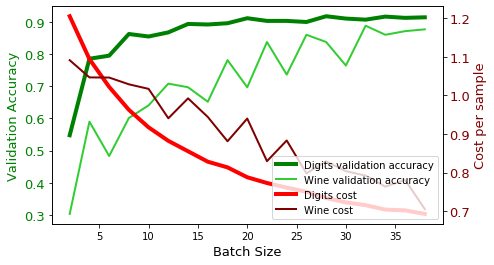

In [22]:
#print(batch_size_results[5][2])

if run_search:
    fig, ax1 = plt.subplots()
    fig.set_size_inches(7,4)

    ax1.plot(batch_size_tests, np.asarray(batch_size_results).T[0], label = f"Digits validation accuracy", color='green',linewidth=4)
    ax1.plot(batch_size_tests, np.asarray(batch_size_results).T[2], label = f"Wine validation accuracy", color='limegreen',linewidth=2)
    ax1.set_ylabel('Validation Accuracy',color='green',fontsize=13)
    ax1.tick_params(axis='y', labelcolor='green', labelsize=13)
    ax1.set_xlabel('Batch Size',fontsize=13)
    ax2 = ax1.twinx() 

    ax2.plot(batch_size_tests, np.asarray(batch_size_results).T[1]/len(digits.data), label = f"Digits cost", color='red',linewidth=4)
    ax2.plot(batch_size_tests, np.asarray(batch_size_results).T[3]/len(wine.data), label = f"Wine cost", color='maroon',linewidth=2)
    ax2.set_ylabel('Cost per sample',color='maroon',fontsize=13)
    ax2.tick_params(axis='y', labelcolor='maroon', labelsize=13)

    handles, labels = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    plt.legend(handles+handles2, labels+labels2,loc='lower right')

    plt.show()
    

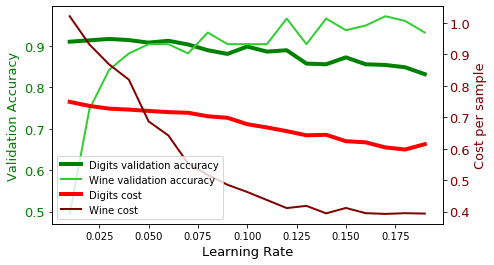

In [23]:
#print(batch_size_results[5][2])

if run_search:
    fig, ax1 = plt.subplots()
    fig.set_size_inches(7,4)

    ax1.plot(learning_rate_tests, np.asarray(learning_rate_results).T[0], label = f"Digits validation accuracy", color='green',linewidth=4)
    ax1.plot(learning_rate_tests, np.asarray(learning_rate_results).T[2], label = f"Wine validation accuracy", color='limegreen',linewidth=2)
    ax1.set_ylabel('Validation Accuracy',color='green',fontsize=13)
    ax1.tick_params(axis='y', labelcolor='green', labelsize=13)
    ax1.set_xlabel('Learning Rate',fontsize=13)
    ax2 = ax1.twinx() 

    ax2.plot(learning_rate_tests, np.asarray(learning_rate_results).T[1]/len(digits.data), label = f"Digits cost", color='red',linewidth=4)
    ax2.plot(learning_rate_tests, np.asarray(learning_rate_results).T[3]/len(wine.data), label = f"Wine cost", color='maroon',linewidth=2)
    ax2.set_ylabel('Cost per sample',color='maroon',fontsize=13)
    ax2.tick_params(axis='y', labelcolor='maroon', labelsize=13)

    handles, labels = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    plt.legend(handles+handles2, labels+labels2,loc='lower left')

    plt.show()



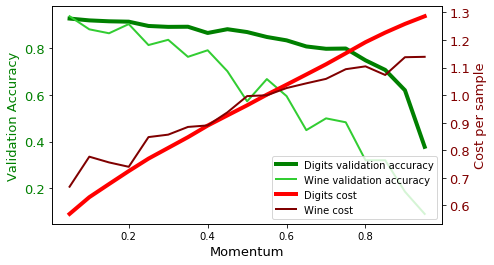

In [24]:
#print(batch_size_results[5][2])

if run_search:
    fig, ax1 = plt.subplots()
    fig.set_size_inches(7,4)

    ax1.plot(momentum_tests, np.asarray(momentum_results).T[0], label = f"Digits validation accuracy", color='green',linewidth=4)
    ax1.plot(momentum_tests, np.asarray(momentum_results).T[2], label = f"Wine validation accuracy", color='limegreen',linewidth=2)
    ax1.set_ylabel('Validation Accuracy',color='green',fontsize=13)
    ax1.tick_params(axis='y', labelcolor='green', labelsize=13)
    ax1.set_xlabel('Momentum',fontsize=13)
    ax2 = ax1.twinx() 

    ax2.plot(momentum_tests, np.asarray(momentum_results).T[1]/len(digits.data), label = f"Digits cost", color='red',linewidth=4)
    ax2.plot(momentum_tests, np.asarray(momentum_results).T[3]/len(wine.data), label = f"Wine cost", color='maroon',linewidth=2)
    ax2.set_ylabel('Cost per sample',color='maroon',fontsize=13)
    ax2.tick_params(axis='y', labelcolor='maroon', labelsize=13)

    handles, labels = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    plt.legend(handles+handles2, labels+labels2,loc='lower right')

    plt.show()

    


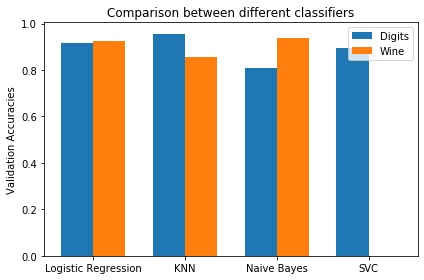

In [25]:
digits_validation_accuracies = [default_run[0],digits_knn_accuracy,digits_naive_accuracy,digits_svc_accuracy]
wine_validation_accuracies = [default_run[2],wine_knn_accuracy,wine_naive_accuracy,0]

labels = ["Logistic Regression","KNN","Naive Bayes","SVC"]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, digits_validation_accuracies, width, label='Digits')
rects2 = ax.bar(x + width/2, wine_validation_accuracies, width, label='Wine')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Validation Accuracies')
ax.set_title('Comparison between different classifiers')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

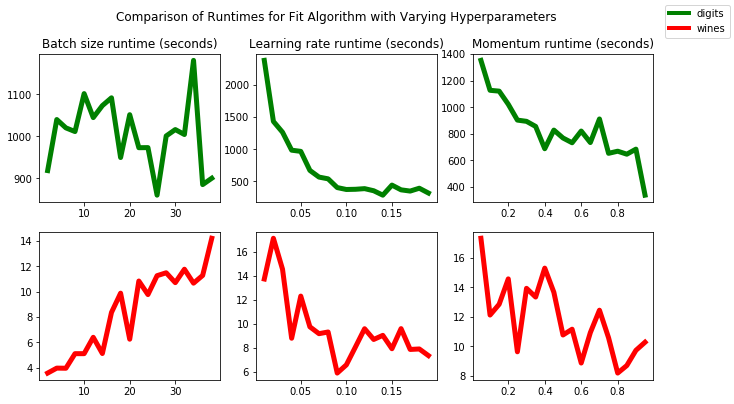

In [76]:
if run_search:
    from matplotlib.lines import Line2D
    fig, ax = plt.subplots(2,3)
    fig.set_figheight(6)
    fig.set_figwidth(11)
    fig.suptitle('Comparison of Runtimes for Fit Algorithm with Varying Hyperparameters')
    
    # Batch size runtime : digits
    ax[0,0].plot(
        batch_size_tests,
        np.asarray(batch_size_results).T[4]/100,
        color='green',linewidth=5, label = f"Batch size runtime : digits")
    ax[0,0].set_title('Batch size runtime (seconds)')
    
    # Learning rate runtimes : digits
    ax[0,1].plot(
        learning_rate_tests,
        np.asarray(learning_rate_results).T[4]/100,
        color='green',linewidth=5, label = f"Learning rate runtimes : digits")
    ax[0,1].set_title('Learning rate runtime (seconds)')

    
    # Momentum runtimes: digits
    ax[0,2].plot(
        momentum_tests,
        np.asarray(momentum_results).T[4]/100,
        color='green',linewidth=5, label = f"Momentum runtimes: digits")
    ax[0,2].set_title('Momentum runtime (seconds)')

    
    # Batch size runtime: wines
    ax[1,0].plot(
        batch_size_tests,
        np.asarray(batch_size_results).T[5]/100,
        color='red',linewidth=5, label = f"Batch size runtime: wines")

    # Learning rate runtimes : wines
    ax[1,1].plot(
        learning_rate_tests,
        np.asarray(learning_rate_results).T[5]/100,
        color='red',linewidth=5, label = f"Learning rate runtimes : wines")
    
    # Momentum runtimes: wines
    ax[1,2].plot(
        momentum_tests,
        np.asarray(momentum_results).T[5]/100,
        color='red',linewidth=5, label = f"Momentum runtimes: wines")

    legend_elements = [Line2D([0], [0], color='g', lw=4, label='digits'),
                       Line2D([0], [0], color='r', lw=4, label='wines')]
    fig.legend(handles=legend_elements)